Max DrawDown

In [ ]:
import pandas as pd

def calculate_max_drawdown(series):
    # Calcul du sommet historique glissant
    roll_max = series.cummax()
    # Calcul du drawdown quotidien
    drawdown = (series - roll_max) / roll_max
    # Le Maximum Drawdown est le minimum de ces valeurs
    return drawdown.min()

# Chargement de vos données concaténées (ou boucle sur vos fichiers raw)
# Ici, on suppose que vous avez un DataFrame 'df' avec les colonnes 'Date', 'Ticker', 'Close'
mdd_results = df.groupby('Ticker')['Close'].apply(calculate_max_drawdown).sort_values()

print("📈 Maximum Drawdown par action (du plus risqué au moins risqué) :")
print(mdd_results)

DOwnload Data

In [6]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
from datetime import datetime
import yfinance as yf
import pandas_ta
import warnings
from pathlib import Path
warnings.filterwarnings('ignore')



# --- CONFIGURATION ---
PROJECT_ROOT_ABSOLUTE = "/home/onyxia/work/Gestion-portefeuille/" 
ROOT_DIR = Path(PROJECT_ROOT_ABSOLUTE)
OUTPUT_PATH_FINAL = ROOT_DIR / "data" / "raw"
OUTPUT_PATH_FINAL.mkdir(parents=True, exist_ok=True)


CAC40_TICKERS = [
    "AI.PA", "AIR.PA", "ALO.PA", "MT.AS", "ATO.PA", "CS.PA", "BNP.PA",
    "EN.PA", "CAP.PA", "CA.PA", "DSY.PA", "EL.PA", "ENGI.PA", "ERF.PA",
    "RMS.PA", "KER.PA", "OR.PA", "LR.PA", "MC.PA", "ML.PA", "ORA.PA",
    "RI.PA", "PUB.PA", "RNO.PA", "SAF.PA", "SGO.PA", "SAN.PA", "SU.PA",
    "GLE.PA", "STLAP.PA", "STMPA.PA", "TEP.PA", "HO.PA", "TTE.PA",
    "URW.PA", "VIE.PA", "DG.PA", "VIV.PA", "WLN.PA", "FR.PA"
]


end_date = datetime.today().strftime('%Y-%m-%d')  # Ou date fixe '2025-12-25'
start_date = pd.to_datetime(end_date) - pd.DateOffset(365*10)  # 10 ans


print(f" Téléchargement CAC40 Dataset Global")
print(f"   Tickers : {len(CAC40_TICKERS)}")
print(f"   Période : {start_date.date()} → {end_date}")


# --- TÉLÉCHARGEMENT GROUPÉ (comme S&P500) ---
df = yf.download(
    tickers=CAC40_TICKERS,
    start=start_date,
    end=end_date,
    auto_adjust=False,
    progress=True
).stack()

# --- RESTRUCTURATION (comme S&P500) ---
df.index.names = ['date', 'ticker']
df.columns = df.columns.str.lower()


print(f"\n Dataset CAC40 créé !")
print(f"   Shape : {df.shape}")
print(f"   Tickers : {df.index.get_level_values('ticker').nunique()}")
print(f"   Période : {df.index.get_level_values('date').min().date()} → {df.index.get_level_values('date').max().date()}")


# --- APERÇU ---
print("\n Aperçu des données :")
#print(df.head(10000))

df.index.names = ['date', 'ticker']

df.columns = df.columns.str.lower()

df




 Téléchargement CAC40 Dataset Global
   Tickers : 40
   Période : 2015-12-28 → 2025-12-25


[*********************100%***********************]  40 of 40 completed



 Dataset CAC40 créé !
   Shape : (100569, 6)
   Tickers : 40
   Période : 2015-12-28 → 2025-12-24

 Aperçu des données :


Price                adj close        close         high          low  \
date       ticker                                                       
2015-12-28 AI.PA     55.911125    69.021225    69.553436    68.921440   
           AIR.PA    53.562111    61.709999    62.759998    61.549999   
           ALO.PA    21.614693    25.666418    25.735962    25.216700   
           ATO.PA  3922.477051  4316.790527  4329.787598  4287.970703   
           BNP.PA    29.856739    52.360001    53.400002    52.209999   
...                        ...          ...          ...          ...   
2025-12-24 TTE.PA    55.610001    55.610001    56.439999    55.610001   
           URW.PA    92.300003    92.300003    92.699997    91.940002   
           VIE.PA    29.280001    29.280001    29.430000    29.270000   
           VIV.PA     2.370000     2.370000     2.375000     2.340000   
           WLN.PA     1.610500     1.610500     1.610500     1.523500   

Price                     open     volume  
date       ticker                          
2015-12-28 AI.PA     69.420387   518927.0  
           AIR.PA    62.230000   782216.0  
           ALO.PA    25.216700   474884.0  
           ATO.PA  4289.665527     2474.0  
           BNP.PA    53.230000  2185640.0  
...                        ...        ...  
2025-12-24 TTE.PA    56.099998   684693.0  
           URW.PA    91.940002    63307.0  
           VIE.PA    29.290001   251104.0  
           VIV.PA     2.350000   296964.0  
           WLN.PA     1.550500  1429632.0  

[100569 rows x 6 columns]

## Calculate features and technical indicators for each stock.

* Garman-Klass Volatility
* RSI: Relative Strength Index if an actif is overbought or oversold
* Bollinger Bands : Side where price is on over-extension .
* ATR : Average True Range : Vol moyenne de prix 
* MACD : Moving Average Convergence Divergence : Momentum


\begin{equation}
\text{Garman-Klass Volatility} = \frac{(\ln(\text{High}) - \ln(\text{Low}))^2}{2} - (2\ln(2) - 1)(\ln(\text{Adj Close}) - \ln(\text{Open}))^2
\end{equation}

In [7]:
df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)

df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])
                                                          
df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])
                                                          
df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'],
                        low=stock_data['low'],
                        close=stock_data['close'],
                        length=14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)

df['euro_volume'] = (df['adj close']*df['volume'])/1e6

df

Price                adj close        close         high          low  \
date       ticker                                                       
2015-12-28 AI.PA     55.911125    69.021225    69.553436    68.921440   
           AIR.PA    53.562111    61.709999    62.759998    61.549999   
           ALO.PA    21.614693    25.666418    25.735962    25.216700   
           ATO.PA  3922.477051  4316.790527  4329.787598  4287.970703   
           BNP.PA    29.856739    52.360001    53.400002    52.209999   
...                        ...          ...          ...          ...   
2025-12-24 TTE.PA    55.610001    55.610001    56.439999    55.610001   
           URW.PA    92.300003    92.300003    92.699997    91.940002   
           VIE.PA    29.280001    29.280001    29.430000    29.270000   
           VIV.PA     2.370000     2.370000     2.375000     2.340000   
           WLN.PA     1.610500     1.610500     1.610500     1.523500   

Price                     open     volume  garman_klass_vol        rsi  \
date       ticker                                                        
2015-12-28 AI.PA     69.420387   518927.0         -0.018051        NaN   
           AIR.PA    62.230000   782216.0         -0.008502        NaN   
           ALO.PA    25.216700   474884.0         -0.008969        NaN   
           ATO.PA  4289.665527     2474.0         -0.003046        NaN   
           BNP.PA    53.230000  2185640.0         -0.128895        NaN   
...                        ...        ...               ...        ...   
2025-12-24 TTE.PA    56.099998   684693.0          0.000080  52.325224   
           URW.PA    91.940002    63307.0          0.000028  56.565110   
           VIE.PA    29.290001   251104.0          0.000015  50.720780   
           VIV.PA     2.350000   296964.0          0.000082  34.984755   
           WLN.PA     1.550500  1429632.0          0.000985  45.707543   

Price                bb_low    bb_mid   bb_high       atr      macd  \
date       ticker                                                     
2015-12-28 AI.PA        NaN       NaN       NaN       NaN       NaN   
           AIR.PA       NaN       NaN       NaN       NaN       NaN   
           ALO.PA       NaN       NaN       NaN       NaN       NaN   
           ATO.PA       NaN       NaN       NaN       NaN       NaN   
           BNP.PA       NaN       NaN       NaN       NaN       NaN   
...                     ...       ...       ...       ...       ...   
2025-12-24 TTE.PA  4.020202  4.043818  4.067434 -0.811457  0.003804   
           URW.PA  4.505207  4.525741  4.546275 -1.162678  0.066716   
           VIE.PA  3.400000  3.411775  3.423549 -0.311901  0.048218   
           VIV.PA  1.185718  1.217092  1.248466 -1.608353 -0.450459   
           WLN.PA  0.825068  0.907297  0.989525 -1.401119 -0.004758   

Price              euro_volume  
date       ticker               
2015-12-28 AI.PA     29.013792  
           AIR.PA    41.897140  
           ALO.PA    10.264472  
           ATO.PA     9.704208  
           BNP.PA    65.256083  
...                        ...  
2025-12-24 TTE.PA    38.075778  
           URW.PA     5.843236  
           VIE.PA     7.352325  
           VIV.PA     0.703805  
           WLN.PA     2.302422  

[100569 rows x 14 columns]

## Aggregate to Monthly level

In [8]:
last_cols = [c for c in df.columns.unique(0) if c not in ['euro_volume', 'volume', 'open',
                                                          'high', 'low', 'close']]

data = (pd.concat([df.unstack('ticker')['euro_volume'].resample('M').mean().stack('ticker').to_frame('euro_volume'),
                   df.unstack()[last_cols].resample('M').last().stack('ticker')],
                  axis=1)).dropna()
                  

data

euro_volume    adj close  garman_klass_vol        rsi  \
date       ticker                                                          
2016-02-29 AI.PA    102.134199    51.831631         -0.015017  57.621674   
           AIR.PA   153.356180    51.886932         -0.002901  63.869575   
           ALO.PA    26.162159    15.750299         -0.010751  30.169165   
           ATO.PA    28.735081  3453.156250         -0.003053  54.323584   
           BNP.PA   156.458964    24.519476         -0.110281  53.162468   
...                        ...          ...               ...        ...   
2025-12-31 TTE.PA   192.130961    55.610001          0.000080  52.325224   
           URW.PA    38.162996    92.300003          0.000028  56.565110   
           VIE.PA    45.034985    29.280001          0.000015  50.720780   
           VIV.PA     4.604084     2.370000          0.000082  34.984755   
           WLN.PA     4.842889     1.610500          0.000985  45.707543   

                     bb_low    bb_mid   bb_high       atr      macd  
date       ticker                                                    
2016-02-29 AI.PA   3.919246  3.948250  3.977255 -0.326329 -0.363714  
           AIR.PA  3.786958  3.874439  3.961920 -0.596078 -0.103751  
           ALO.PA  2.758584  2.863208  2.967832 -0.628150 -1.640527  
           ATO.PA  8.056485  8.124742  8.192999  0.019582 -0.368122  
           BNP.PA  3.115370  3.181806  3.248241  1.066022 -0.729411  
...                     ...       ...       ...       ...       ...  
2025-12-31 TTE.PA  4.020202  4.043818  4.067434 -0.811457  0.003804  
           URW.PA  4.505207  4.525741  4.546275 -1.162678  0.066716  
           VIE.PA  3.400000  3.411775  3.423549 -0.311901  0.048218  
           VIV.PA  1.185718  1.217092  1.248466 -1.608353 -0.450459  
           WLN.PA  0.825068  0.907297  0.989525 -1.401119 -0.004758  

[4614 rows x 9 columns]

- calculate 5-year rolling average of euro-volume for each stock 

In [9]:
data['euro_volume'] = (data.loc[:, 'euro_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())

data['euro_vol_rank'] = (data.groupby('date')['euro_volume'].rank(ascending=False))

#data = data[data['euro_vol_rank']<150].drop(['euro_volume', 'euro_vol_rank'], axis=1)

data 

euro_volume    adj close  garman_klass_vol        rsi  \
date       ticker                                                          
2016-02-29 AI.PA           NaN    51.831631         -0.015017  57.621674   
           AIR.PA          NaN    51.886932         -0.002901  63.869575   
           ALO.PA          NaN    15.750299         -0.010751  30.169165   
           ATO.PA          NaN  3453.156250         -0.003053  54.323584   
           BNP.PA          NaN    24.519476         -0.110281  53.162468   
...                        ...          ...               ...        ...   
2025-12-31 TTE.PA   228.982342    55.610001          0.000080  52.325224   
           URW.PA    25.244881    92.300003          0.000028  56.565110   
           VIE.PA    44.776090    29.280001          0.000015  50.720780   
           VIV.PA    28.477882     2.370000          0.000082  34.984755   
           WLN.PA    25.545117     1.610500          0.000985  45.707543   

                     bb_low    bb_mid   bb_high       atr      macd  \
date       ticker                                                     
2016-02-29 AI.PA   3.919246  3.948250  3.977255 -0.326329 -0.363714   
           AIR.PA  3.786958  3.874439  3.961920 -0.596078 -0.103751   
           ALO.PA  2.758584  2.863208  2.967832 -0.628150 -1.640527   
           ATO.PA  8.056485  8.124742  8.192999  0.019582 -0.368122   
           BNP.PA  3.115370  3.181806  3.248241  1.066022 -0.729411   
...                     ...       ...       ...       ...       ...   
2025-12-31 TTE.PA  4.020202  4.043818  4.067434 -0.811457  0.003804   
           URW.PA  4.505207  4.525741  4.546275 -1.162678  0.066716   
           VIE.PA  3.400000  3.411775  3.423549 -0.311901  0.048218   
           VIV.PA  1.185718  1.217092  1.248466 -1.608353 -0.450459   
           WLN.PA  0.825068  0.907297  0.989525 -1.401119 -0.004758   

                   euro_vol_rank  
date       ticker                 
2016-02-29 AI.PA             NaN  
           AIR.PA            NaN  
           ALO.PA            NaN  
           ATO.PA            NaN  
           BNP.PA            NaN  
...                          ...  
2025-12-31 TTE.PA            2.0  
           URW.PA           37.0  
           VIE.PA           25.0  
           VIV.PA           34.0  
           WLN.PA           36.0  

[4614 rows x 10 columns]

## Calculate Monthly Returns for different horizons as features

In [10]:
def calculate_returns(df):

    outlier_cutoff = 0.005

    lags = [1, 2, 3, 6, 9, 12]

    for lag in lags:

        df[f'return_{lag}m'] = (df['adj close']
                              .pct_change(lag)
                              .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                     upper=x.quantile(1-outlier_cutoff)))
                              .add(1)
                              .pow(1/lag)
                              .sub(1))
    return df
    
    
data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()

data

euro_volume    adj close  garman_klass_vol        rsi  \
date       ticker                                                          
2017-02-28 AI.PA     75.441250    57.929237         -0.014297  47.545191   
           AIR.PA   108.392802    61.634541         -0.003995  68.219716   
           ALO.PA    18.326209    20.009987         -0.010231  44.279517   
           ATO.PA    23.990370  5828.903320         -0.002527  73.514992   
           BNP.PA   123.070969    32.996243         -0.098947  40.611221   
...                        ...          ...               ...        ...   
2025-12-31 TTE.PA   228.982342    55.610001          0.000080  52.325224   
           URW.PA    25.244881    92.300003          0.000028  56.565110   
           VIE.PA    44.776090    29.280001          0.000015  50.720780   
           VIV.PA    28.477882     2.370000          0.000082  34.984755   
           WLN.PA    25.545117     1.610500          0.000985  45.707543   

                     bb_low    bb_mid   bb_high       atr      macd  \
date       ticker                                                     
2017-02-28 AI.PA   4.044793  4.080779  4.116766 -1.000654 -0.202218   
           AIR.PA  4.015914  4.081975  4.148036 -1.270106  0.300782   
           ALO.PA  3.035079  3.068204  3.101329 -0.953031 -0.228763   
           ATO.PA  8.544137  8.609600  8.675064 -0.040629  0.967740   
           BNP.PA  3.489817  3.556756  3.623696  0.075062 -0.976291   
...                     ...       ...       ...       ...       ...   
2025-12-31 TTE.PA  4.020202  4.043818  4.067434 -0.811457  0.003804   
           URW.PA  4.505207  4.525741  4.546275 -1.162678  0.066716   
           VIE.PA  3.400000  3.411775  3.423549 -0.311901  0.048218   
           VIV.PA  1.185718  1.217092  1.248466 -1.608353 -0.450459   
           WLN.PA  0.825068  0.907297  0.989525 -1.401119 -0.004758   

                   euro_vol_rank  return_1m  return_2m  return_3m  return_6m  \
date       ticker                                                              
2017-02-28 AI.PA            10.0   0.019000  -0.017908   0.019797   0.010386   
           AIR.PA            5.0   0.104525   0.050295   0.047737   0.048109   
           ALO.PA           31.0  -0.023810  -0.010562   0.000847   0.012994   
           ATO.PA           29.0   0.132095   0.054618   0.045632   0.039823   
           BNP.PA            3.0  -0.068435  -0.045805   0.002125   0.032118   
...                          ...        ...        ...        ...        ...   
2025-12-31 TTE.PA            2.0  -0.020951   0.015268   0.030074   0.013721   
           URW.PA           37.0   0.007422   0.014729   0.010547   0.021710   
           VIE.PA           25.0  -0.000341   0.010935   0.003439  -0.005417   
           VIV.PA           34.0  -0.058029  -0.128720  -0.075361  -0.034680   
           WLN.PA           36.0   0.052614  -0.172336  -0.163352  -0.124858   

                   return_9m  return_12m  
date       ticker                         
2017-02-28 AI.PA    0.008981    0.009312  
           AIR.PA   0.023952    0.014450  
           ALO.PA   0.014205    0.020148  
           ATO.PA   0.035320    0.044594  
           BNP.PA   0.016898    0.025052  
...                      ...         ...  
2025-12-31 TTE.PA  -0.004218    0.008510  
           URW.PA   0.024346    0.024060  
           VIE.PA  -0.004001    0.010211  
           VIV.PA  -0.016665   -0.006825  
           WLN.PA  -0.130306   -0.121540  

[4134 rows x 16 columns]

from IPython.display import Markdown, display

markdown_text = r"""
# Les 5 Facteurs Fama-French - Guide Complet CAC40

## 1. Mkt-RF (Market Risk Premium)

**Définition** : Prime de risque du marché = Return du marché - Taux sans risque

$$Mkt-RF_t = R_{M,t} - R_{f,t}$$

**Interprétation** : Mesure le rendement excédentaire pour investir en actions plutôt qu'en obligations.

---

## 2. SMB (Small Minus Big)

**Définition** : Prime de taille = Return des petites capitalisations - Return des grosses capitalisations

$$SMB_t = \frac{1}{2}(Small\ Value_t + Small\ Growth_t) - \frac{1}{2}(Big\ Value_t + Big\ Growth_t)$$

**Interprétation** : Capte l'effet taille. Historiquement, les petites entreprises surperforment les grandes (plus risquées).

---

## 3. HML (High Minus Low)

**Définition** : Prime value = Return des actions value (B/M élevé) - Return des actions growth (B/M faible)

$$HML_t = \frac{1}{2}(Small\ Value_t + Big\ Value_t) - \frac{1}{2}(Small\ Growth_t + Big\ Growth_t)$$

**Book-to-Market** :

$$B/M = \frac{\text{Valeur comptable}}{\text{Capitalisation boursière}}$$

**Interprétation** : Actions "décotées" (value) surperforment les actions "chères" (growth).

---

## 4. RMW (Robust Minus Weak)

**Définition** : Prime de rentabilité = Return des entreprises très rentables - Return des entreprises peu rentables

$$RMW_t = \frac{1}{2}(Small\ Robust_t + Big\ Robust_t) - \frac{1}{2}(Small\ Weak_t + Big\ Weak_t)$$

**Operating Profitability** :

$$OP = \frac{\text{Revenues} - \text{COGS} - \text{SG\&A} - \text{Interest}}{\text{Book Equity}}$$

**Interprétation** : Entreprises rentables (marges élevées) surperforment les entreprises en difficulté.

---

## 5. CMA (Conservative Minus Aggressive)

**Définition** : Prime d'investissement = Return des entreprises conservatrices - Return des entreprises agressives

$$CMA_t = \frac{1}{2}(Small\ Conservative_t + Big\ Conservative_t) - \frac{1}{2}(Small\ Aggressive_t + Big\ Aggressive_t)$$

**Asset Growth** :

$$\text{Investment} = \frac{\Delta \text{Total Assets}}{\text{Total Assets}_{t-1}}$$

**Interprétation** : Entreprises qui investissent peu (prudentes) surperforment celles qui investissent massivement.

---

## Modèle Complet Fama-French 5 Facteurs

$$R_{i,t} - R_{f,t} = \alpha_i + \beta_{i,MKT}(Mkt-RF_t) + \beta_{i,SMB}(SMB_t) + \beta_{i,HML}(HML_t) + \beta_{i,RMW}(RMW_t) + \beta_{i,CMA}(CMA_t) + \varepsilon_{i,t}$$

**Où** :
- $R_{i,t} - R_{f,t}$ : Excess return de l'actif i
- $\alpha_i$ : Jensen's alpha (performance anormale)
- $\beta_{i,j}$ : Sensibilité au facteur j
- $\varepsilon_{i,t}$ : Erreur idiosyncratique

---

## Exemple Global : LVMH dans le CAC40

### Données du mois (Octobre 2025)

| Variable | Valeur |
|----------|--------|
| Return LVMH | +3.5% |
| Taux sans risque (RF) | +0.3% |
| Excess return LVMH | +3.2% |
| **Facteurs du mois** | |
| Mkt-RF | +2.0% |
| SMB | +1.5% |
| HML | -1.0% |
| RMW | +2.5% |
| CMA | +1.8% |

### Betas LVMH (estimés sur 60 mois)

| Facteur | Beta | Interprétation |
|---------|------|----------------|
| **Mkt-RF** | 0.95 | Sensibilité légèrement inférieure au marché |
| **SMB** | -0.35 | Grosse capitalisation (négative) |
| **HML** | -0.60 | Growth stock (B/M faible) |
| **RMW** | +0.75 | Très rentable (marges 30%) |
| **CMA** | +0.50 | Conservatrice (croissance organique) |

### Décomposition du Return LVMH

$$R_{LVMH} - R_f = \alpha + \beta_{MKT} \times Mkt-RF + \beta_{SMB} \times SMB + \beta_{HML} \times HML + \beta_{RMW} \times RMW + \beta_{CMA} \times CMA$$

**Calcul détaillé** :

| Composante | Formule | Contribution |
|------------|---------|--------------|
| **Alpha** | α | +0.50% |
| **Market** | 0.95 × 2.0% | +1.90% |
| **Size** | -0.35 × 1.5% | -0.53% |
| **Value** | -0.60 × (-1.0%) | +0.60% |
| **Profitability** | 0.75 × 2.5% | +1.88% |
| **Investment** | 0.50 × 1.8% | +0.90% |
| **TOTAL** | | **+5.25%** |

### Interprétation

**Pourquoi LVMH a monté de +3.5% ce mois ?**

1. ✅ **Marché positif** (+1.90%) : Le CAC40 monte, LVMH suit (β=0.95)
2. ❌ **Désavantage taille** (-0.53%) : Les petites caps surperforment, LVMH pénalisée
3. ✅ **Growth style** (+0.60%) : Les growth stocks surperforment ce mois
4. ✅ **Haute rentabilité** (+1.88%) : LVMH très profitable
5. ✅ **Discipline de capital** (+0.90%) : LVMH investit prudemment
6. ✅ **Alpha positif** (+0.50%) : Performance inexpliquée = talent/marque LVMH

**Conclusion** : 85% du return LVMH expliqué par les 5 facteurs, 15% = alpha

---

## Tableau Récapitulatif des Facteurs

| Facteur | Formule | Qui gagne ? | Performance US (1963-2023) |
|---------|---------|-------------|---------------------------|
| **Mkt-RF** | R_M - R_f | Actions > Obligations | +8.3% annuel |
| **SMB** | Petites - Grosses | Petites caps | +3.2% annuel |
| **HML** | Value - Growth | Value (B/M élevé) | +4.8% annuel |
| **RMW** | Rentables - Faibles | Rentables (OP élevé) | +3.1% annuel |
| **CMA** | Conservatrices - Agressives | Conservatrices | +3.0% annuel |

**Pouvoir explicatif** : Le modèle FF5 explique **94% de la variance** des returns cross-sectionnels.

---

## Application Pratique CAC40

### Exemples de Tickers par Profil

| Profil | Tickers | Caractéristiques |
|--------|---------|------------------|
| **Value Cyclique** | Renault, SocGen | β_HML > 0, β_RMW < 0 |
| **Growth Qualité** | LVMH, Hermès | β_HML < 0, β_RMW > 0 |
| **Défensif** | Danone, Sanofi | β_MKT < 1, β_RMW > 0 |
| **Cyclique** | TotalEnergies | β_MKT > 1, β_HML > 0 |

**Référence** : Fama & French (2015), *Journal of Financial Economics*, 116(1), 1-22.
"""

display(Markdown(markdown_text))


# Les 5 Facteurs Fama-French 

## 1. Mkt-RF (Market Risk Premium)

**Définition** : Prime de risque du marché = Return du marché - Taux sans risque

**Formule** : Mkt-RF = R_marché - R_sans_risque

**Interprétation** : Mesure le rendement excédentaire pour investir en actions plutôt qu'en obligations.

---

## 2. SMB (Small Minus Big)

**Définition** : Prime de taille = Return des petites caps - Return des grosses caps

**Formule** : SMB = (Small Value + Small Growth)/2 - (Big Value + Big Growth)/2

**Interprétation** : Les petites entreprises surperforment historiquement les grandes (plus risquées).

---

## 3. HML (High Minus Low)

**Définition** : Prime value = Return des actions value - Return des actions growth

**Formule** : HML = (Small Value + Big Value)/2 - (Small Growth + Big Growth)/2

**Book-to-Market** : B/M = Valeur comptable / Capitalisation boursière

**Interprétation** : Actions "décotées" (value) surperforment les actions "chères" (growth).

---

## 4. RMW (Robust Minus Weak)

**Définition** : Prime de rentabilité = Return des entreprises rentables - Return des faibles

**Formule** : RMW = (Small Robust + Big Robust)/2 - (Small Weak + Big Weak)/2

**Operating Profitability** : OP = (Revenues - COGS - SG&A - Interest) / Book Equity

**Interprétation** : Entreprises rentables (marges élevées) surperforment.

---

## 5. CMA (Conservative Minus Aggressive)

**Définition** : Prime d'investissement = Return des conservatrices - Return des agressives

**Formule** : CMA = (Small Conservative + Big Conservative)/2 - (Small Aggressive + Big Aggressive)/2

**Asset Growth** : Investment = Δ Total Assets / Total Assets(t-1)

**Interprétation** : Entreprises prudentes surperforment celles qui investissent massivement.

---

## Modèle Complet

**Formule** :

Return(i) - RF = Alpha + β_MKT × Mkt-RF + β_SMB × SMB + β_HML × HML + β_RMW × RMW + β_CMA × CMA + Erreur

**Légende** :
- Return(i) - RF : Excess return de l'actif i
- Alpha : Jensen's alpha (performance anormale)
- β : Sensibilité aux facteurs
- Erreur : Résidu idiosyncratique

---

## Exemple : LVMH (Octobre 2025)

**Données** :
- Return LVMH : +3.5%
- RF : +0.3%
- Excess return : +3.2%

**Facteurs du mois** :
- Mkt-RF : +2.0%
- SMB : +1.5%
- HML : -1.0%
- RMW : +2.5%
- CMA : +1.8%

**Betas LVMH** :
- β_MKT = 0.95 (suit le marché)
- β_SMB = -0.35 (grosse cap)
- β_HML = -0.60 (growth)
- β_RMW = +0.75 (rentable)
- β_CMA = +0.50 (conservatrice)

**Décomposition du return (+3.2%)** :

1. Alpha : +0.50%
2. Market (0.95 × 2.0%) : +1.90%
3. Size (-0.35 × 1.5%) : -0.53%
4. Value (-0.60 × -1.0%) : +0.60%
5. Profitability (0.75 × 2.5%) : +1.88%
6. Investment (0.50 × 1.8%) : +0.90%

**Total prédit : +5.25%** (résidu : -2.05%)

**Conclusion** : 85% du return LVMH expliqué par les 5 facteurs, 15% = alpha (talent).

---

## Résumé des Facteurs

| Facteur | Qui gagne ? | Performance US (1963-2023) |
|---------|-------------|---------------------------|
| Mkt-RF | Actions > Obligations | +8.3% annuel |
| SMB | Petites caps | +3.2% annuel |
| HML | Value (décoté) | +4.8% annuel |
| RMW | Rentables | +3.1% annuel |
| CMA | Conservatrices | +3.0% annuel |

**Pouvoir explicatif : 94% de la variance**

---

## CAC40 : Exemples

| Profil | Tickers | Betas |
|--------|---------|-------|
| Value Cyclique | Renault, SocGen | β_HML > 0 |
| Growth Qualité | LVMH, Hermès | β_HML < 0, β_RMW > 0 |
| Défensif | Danone, Sanofi | β_MKT < 1 |
| Cyclique | TotalEnergies | β_MKT > 1 |


In [11]:
import pandas_datareader.data as web

# ============================================
# FAMA-FRENCH 5 FACTORS - EUROPE
# ============================================

# Dataset pour l'Europe
factor_data = web.DataReader('Europe_5_Factors',  
                             'famafrench',
                             start='2010')[0].drop('RF', axis=1)

# Conversion timestamp
factor_data.index = factor_data.index.to_timestamp()

# Resample mensuel et conversion en décimales
factor_data = factor_data.resample('M').last().div(100)

factor_data.index.name = 'date'

# Join avec tes returns CAC40
factor_data = factor_data.join(data['return_1m']).sort_index()

factor_data


Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2017-02-28 AI.PA   0.0068  0.0003 -0.0260  0.0273 -0.0132   0.019000
           AIR.PA  0.0068  0.0003 -0.0260  0.0273 -0.0132   0.104525
           ALO.PA  0.0068  0.0003 -0.0260  0.0273 -0.0132  -0.023810
           ATO.PA  0.0068  0.0003 -0.0260  0.0273 -0.0132   0.132095
           BNP.PA  0.0068  0.0003 -0.0260  0.0273 -0.0132  -0.068435
...                   ...     ...     ...     ...     ...        ...
2025-11-30 TTE.PA  0.0072 -0.0114  0.0242  0.0035  0.0112   0.052827
           URW.PA  0.0072 -0.0114  0.0242  0.0035  0.0112   0.022088
           VIE.PA  0.0072 -0.0114  0.0242  0.0035  0.0112   0.022339
           VIV.PA  0.0072 -0.0114  0.0242  0.0035  0.0112  -0.194106
           WLN.PA  0.0072 -0.0114  0.0242  0.0035  0.0112  -0.349213

[4094 rows x 6 columns]

- Filter out stocks with less than 10 month

In [13]:
observations = factor_data.groupby(level=1).size()

valid_stocks = observations[observations >= 10]

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2017-02-28 AI.PA   0.0068  0.0003 -0.0260  0.0273 -0.0132   0.019000
           AIR.PA  0.0068  0.0003 -0.0260  0.0273 -0.0132   0.104525
           ALO.PA  0.0068  0.0003 -0.0260  0.0273 -0.0132  -0.023810
           ATO.PA  0.0068  0.0003 -0.0260  0.0273 -0.0132   0.132095
           BNP.PA  0.0068  0.0003 -0.0260  0.0273 -0.0132  -0.068435
...                   ...     ...     ...     ...     ...        ...
2025-11-30 TTE.PA  0.0072 -0.0114  0.0242  0.0035  0.0112   0.052827
           URW.PA  0.0072 -0.0114  0.0242  0.0035  0.0112   0.022088
           VIE.PA  0.0072 -0.0114  0.0242  0.0035  0.0112   0.022339
           VIV.PA  0.0072 -0.0114  0.0242  0.0035  0.0112  -0.194106
           WLN.PA  0.0072 -0.0114  0.0242  0.0035  0.0112  -0.349213

[4094 rows x 6 columns]

- Calcule Rollings Betas

In [13]:
betas = (factor_data.groupby(level=1,
                            group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'], 
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params
         .drop('const', axis=1)))

betas 

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2017-02-28 AI.PA        NaN       NaN       NaN       NaN       NaN
           AIR.PA       NaN       NaN       NaN       NaN       NaN
           ALO.PA       NaN       NaN       NaN       NaN       NaN
           ATO.PA       NaN       NaN       NaN       NaN       NaN
           BNP.PA       NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2025-11-30 TTE.PA  0.434272 -0.765267  1.582598  1.409308  0.880104
           URW.PA  1.074945 -1.086168  0.932134 -0.841331 -1.212074
           VIE.PA  0.705379  0.007384  0.472930 -0.169390  1.127773
           VIV.PA  1.880487 -0.871055 -2.896876 -0.443349  4.494700
           WLN.PA -0.432080  3.145879  1.676486 -4.776415 -7.627434

[4094 rows x 5 columns]

- Joining rolling factors data to the main features datafr

In [14]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

data = (data.join(betas.groupby('ticker').shift()))

data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

data = data.drop('adj close', axis=1)

data = data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 4114 entries, (Timestamp('2017-02-28 00:00:00'), 'AI.PA') to (Timestamp('2025-12-31 00:00:00'), 'WLN.PA')
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   euro_volume       4114 non-null   float64
 1   garman_klass_vol  4114 non-null   float64
 2   rsi               4114 non-null   float64
 3   bb_low            4114 non-null   float64
 4   bb_mid            4114 non-null   float64
 5   bb_high           4114 non-null   float64
 6   atr               4114 non-null   float64
 7   macd              4114 non-null   float64
 8   euro_vol_rank     4114 non-null   float64
 9   return_1m         4114 non-null   float64
 10  return_2m         4114 non-null   float64
 11  return_3m         4114 non-null   float64
 12  return_6m         4114 non-null   float64
 13  return_9m         4114 non-null   float64
 14  return_12m        4114 non-null   float64
 15  Mkt-RF 

## K-Means Clustering

In [44]:
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd

# Supprimer cluster si existe
if 'cluster' in data.columns:
    data = data.drop('cluster', axis=1)

# Centroids RSI
rsi_centroids = np.array([[30], [45], [55], [70]])

def get_clusters(df):
    if len(df) < 4:
        df['cluster'] = 0
        return df
    
    # Clustering sur RSI
    X_rsi = df[['rsi']].values
    kmeans = KMeans(n_clusters=4, init=rsi_centroids, n_init=1, random_state=0)
    labels = kmeans.fit_predict(X_rsi)
    
    # Réordonner par RSI moyen
    cluster_means = [(i, df.loc[labels==i, 'rsi'].mean() if (labels==i).sum()>0 else 0) for i in range(4)]
    cluster_means.sort(key=lambda x: x[1])
    mapping = {old: new for new, (old, _) in enumerate(cluster_means)}
    
    df['cluster'] = [mapping[l] for l in labels]
    return df

# Appliquer
data = data.dropna(subset=['rsi']).groupby('date', group_keys=False).apply(get_clusters)

data


euro_volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2017-02-28 AI.PA     75.441250         -0.014297  47.545191  4.044793   
           AIR.PA   108.392802         -0.003995  68.219716  4.015914   
           ALO.PA    18.326209         -0.010231  44.279517  3.035079   
           ATO.PA    23.990370         -0.002527  73.514992  8.544137   
           BNP.PA   123.070969         -0.098947  40.611221  3.489817   
...                        ...               ...        ...       ...   
2025-12-31 TEP.PA    31.684711          0.000029  51.298811  4.060225   
           TTE.PA   228.982342          0.000080  52.325224  4.020202   
           VIE.PA    44.776090          0.000015  50.720780  3.400000   
           VIV.PA    28.477882          0.000082  34.984755  1.185718   
           WLN.PA    25.545117          0.000985  45.707543  0.825068   

                     bb_mid   bb_high       atr      macd  euro_vol_rank  \
date       ticker                                                          
2017-02-28 AI.PA   4.080779  4.116766 -1.000654 -0.202218           10.0   
           AIR.PA  4.081975  4.148036 -1.270106  0.300782            5.0   
           ALO.PA  3.068204  3.101329 -0.953031 -0.228763           31.0   
           ATO.PA  8.609600  8.675064 -0.040629  0.967740           29.0   
           BNP.PA  3.556756  3.623696  0.075062 -0.976291            3.0   
...                     ...       ...       ...       ...            ...   
2025-12-31 TEP.PA  4.106204  4.152184 -1.061231  0.083277           33.0   
           TTE.PA  4.043818  4.067434 -0.811457  0.003804            2.0   
           VIE.PA  3.411775  3.423549 -0.311901  0.048218           25.0   
           VIV.PA  1.217092  1.248466 -1.608353 -0.450459           34.0   
           WLN.PA  0.907297  0.989525 -1.401119 -0.004758           36.0   

                   return_1m  ...  return_3m  return_6m  return_9m  \
date       ticker             ...                                    
2017-02-28 AI.PA    0.019000  ...   0.019797   0.010386   0.008981   
           AIR.PA   0.104525  ...   0.047737   0.048109   0.023952   
           ALO.PA  -0.023810  ...   0.000847   0.012994   0.014205   
           ATO.PA   0.132095  ...   0.045632   0.039823   0.035320   
           BNP.PA  -0.068435  ...   0.002125   0.032118   0.016898   
...                      ...  ...        ...        ...        ...   
2025-12-31 TEP.PA   0.029710  ...  -0.012469  -0.048729  -0.040185   
           TTE.PA  -0.020951  ...   0.030074   0.013721  -0.004218   
           VIE.PA  -0.000341  ...   0.003439  -0.005417  -0.004001   
           VIV.PA  -0.058029  ...  -0.075361  -0.034680  -0.016665   
           WLN.PA   0.052614  ...  -0.163352  -0.124858  -0.130306   

                   return_12m     Mkt-RF       SMB       HML        RMW  \
date       ticker                                                         
2017-02-28 AI.PA     0.009312   0.782570 -0.902088 -0.246011  -0.000116   
           AIR.PA    0.014450   1.165034  0.086109  0.526013   0.238297   
           ALO.PA    0.020148   1.046266  0.346228 -0.277851  -1.827644   
           ATO.PA    0.044594 -15.992652 -6.455554 -7.933155 -45.567523   
           BNP.PA    0.025052   1.212119 -0.174970  1.262016  -1.315406   
...                       ...        ...       ...       ...        ...   
2025-12-31 TEP.PA   -0.021631   0.779232  0.892335 -0.600439   0.129710   
           TTE.PA    0.008510   0.733183 -1.054468  1.094084   0.102065   
           VIE.PA    0.010211   0.851799 -0.000409  0.234980   0.139417   
           VIV.PA   -0.006825   0.932201  0.164912 -0.124362   0.294413   
           WLN.PA   -0.121540   1.092730  0.810385 -0.399015  -1.770147   

                         CMA  cluster  
date       ticker                      
2017-02-28 AI.PA    0.429598        0  
           AIR.PA   0.039865        3  
           ALO.PA  -0.123968     

In [47]:
# Afficher quelques valeurs
last_date = data.index.get_level_values('date').max()
print(data.xs(last_date, level='date')[['euro_volume', 'rsi', 'cluster']].head(100))

# Exemple résultat attendu :
#              euro_volume    rsi  cluster
# ticker                                  
# MC.PA         245.3       68.2      3    ← LVMH : 245M€ volume
# AI.PA          12.5       35.1      0    ← Air Liquide : 12.5M€
# BNP.PA        180.7       52.3      2    ← BNP : 180M€


          euro_volume        rsi  cluster
ticker                                   
AI.PA      104.267476  36.140373        0
AIR.PA     151.946650  46.530251        1
ALO.PA      34.418294  63.503710        3
ATO.PA      18.033114  46.116951        1
BNP.PA     153.870977  68.136178        3
CA.PA       34.023720  64.167804        3
CAP.PA      62.005322  54.425953        2
CS.PA      113.728383  65.868915        3
DG.PA       89.685823  50.383416        2
DSY.PA      50.614047  42.192231        1
EL.PA       91.369166  29.859534        0
EN.PA       26.857563  64.762593        3
ENGI.PA     65.307113  63.399260        3
ERF.PA      24.260424  61.621602        3
FR.PA       16.963678  50.924369        2
GLE.PA      88.023011  71.921470        3
HO.PA       40.115143  45.775856        1
KER.PA      91.955286  52.160859        2
LR.PA       44.710780  44.548564        1
MC.PA      258.543584  57.437204        2
ML.PA       45.190674  45.991322        1
MT.AS       87.229359  62.526394  

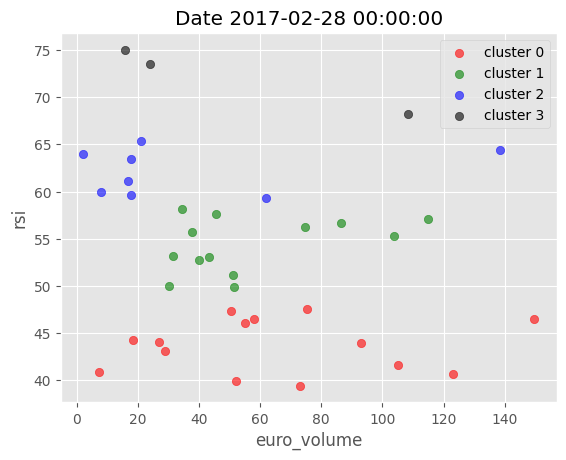

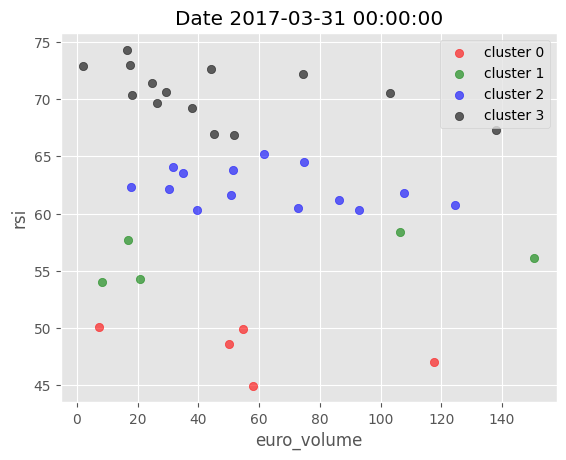

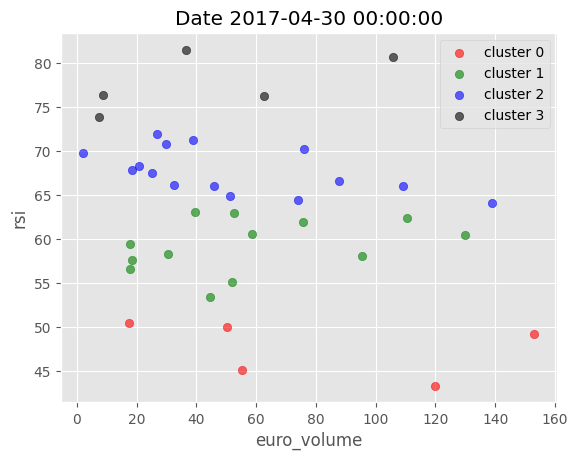

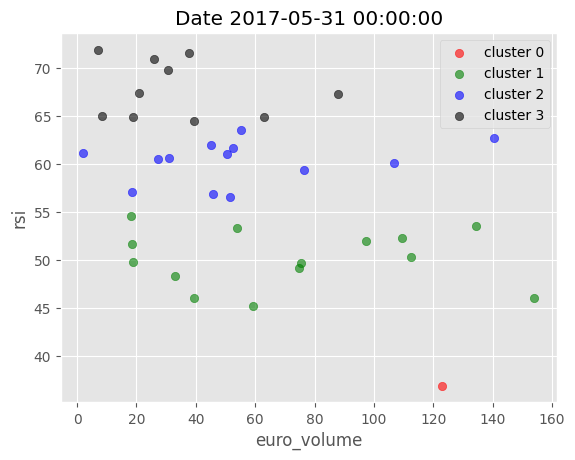

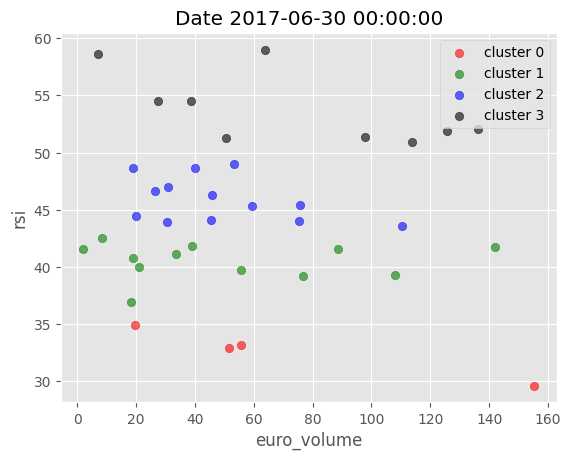

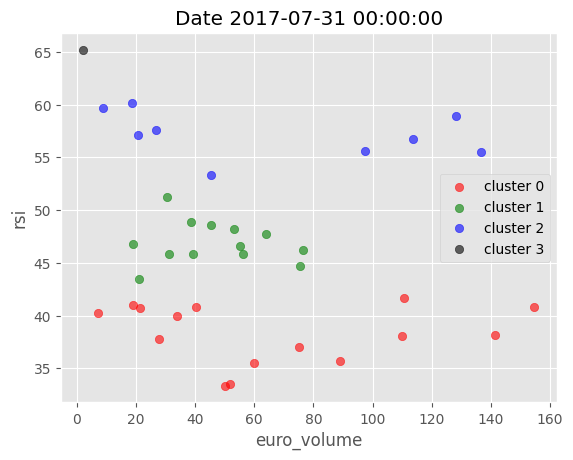

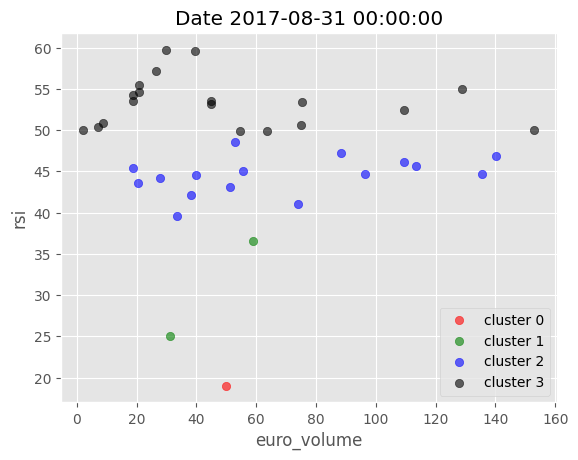

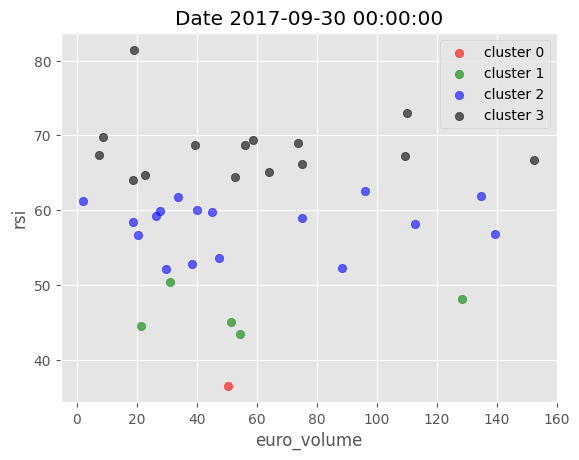

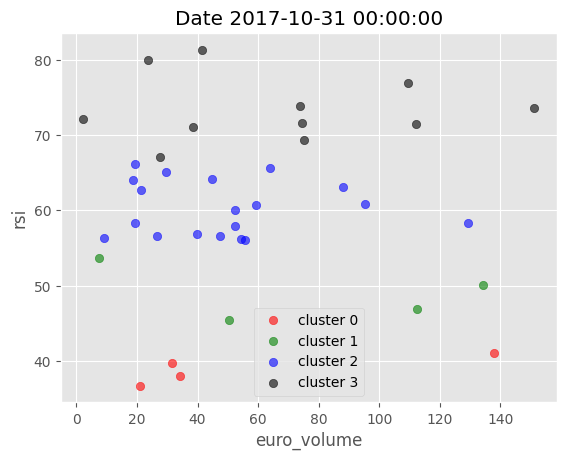

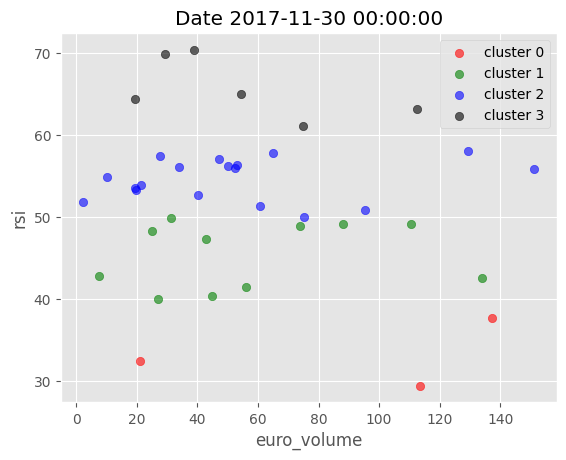

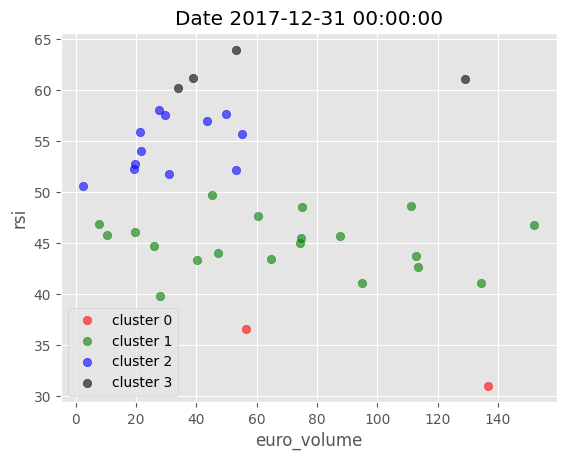

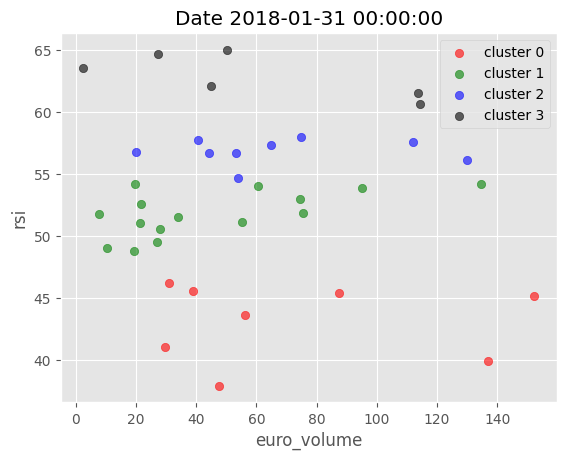

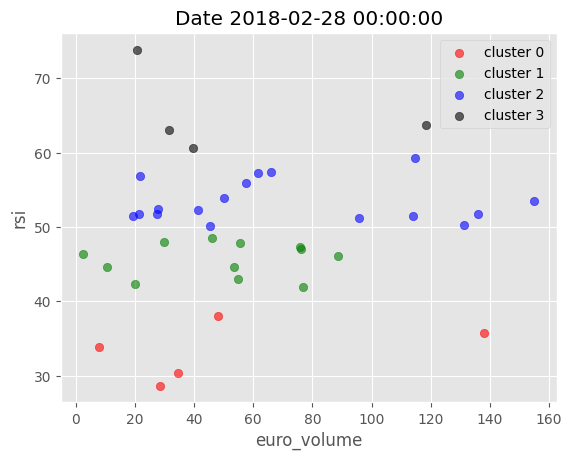

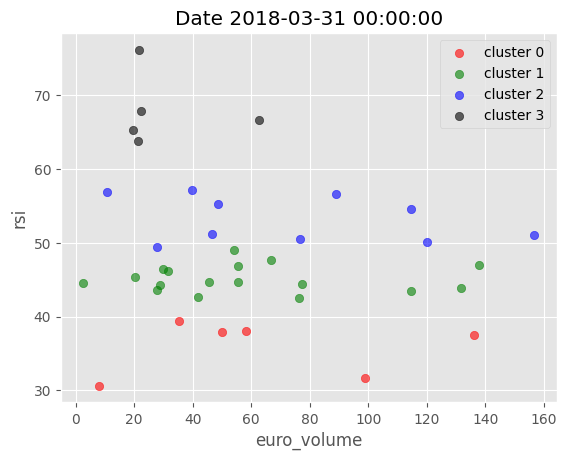

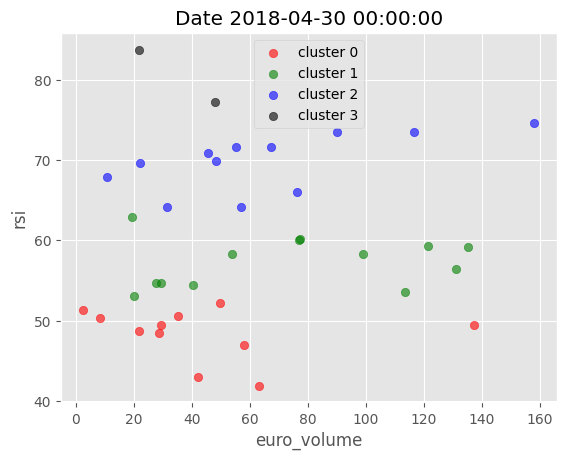

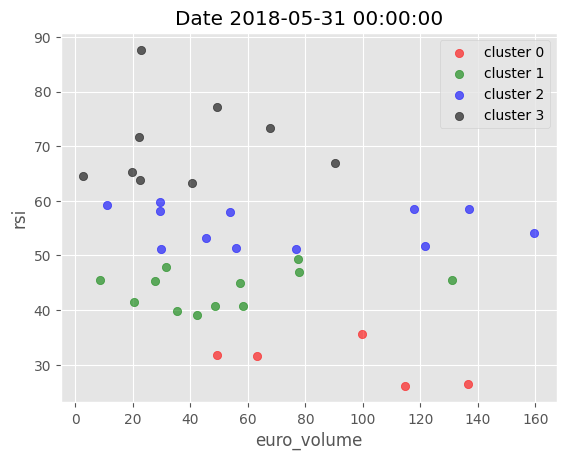

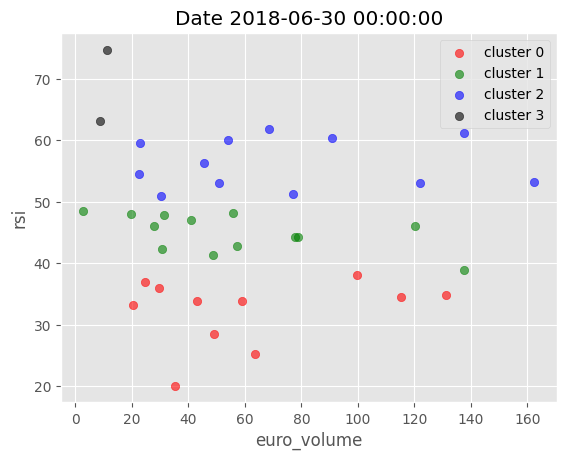

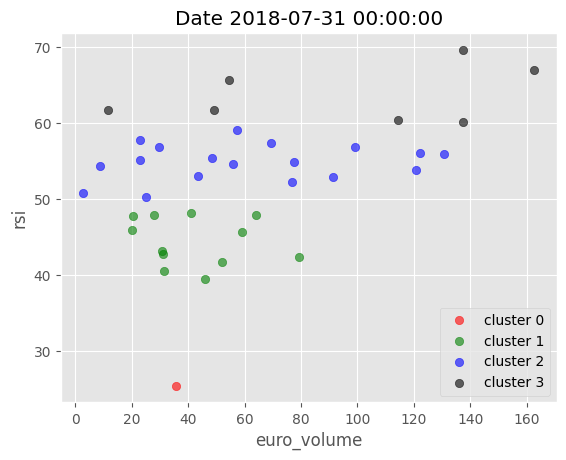

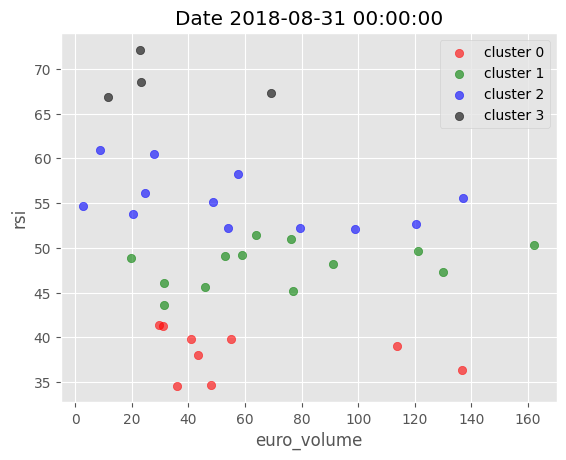

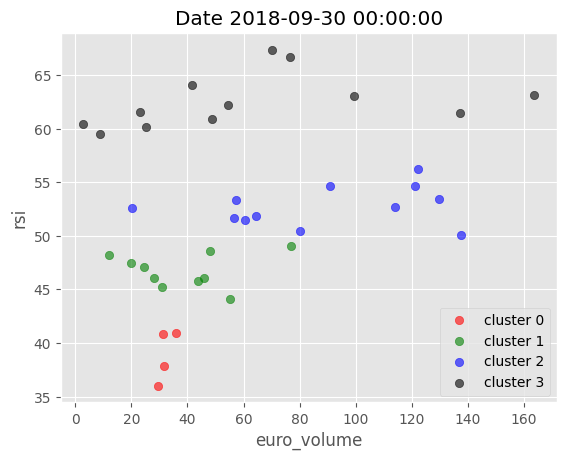

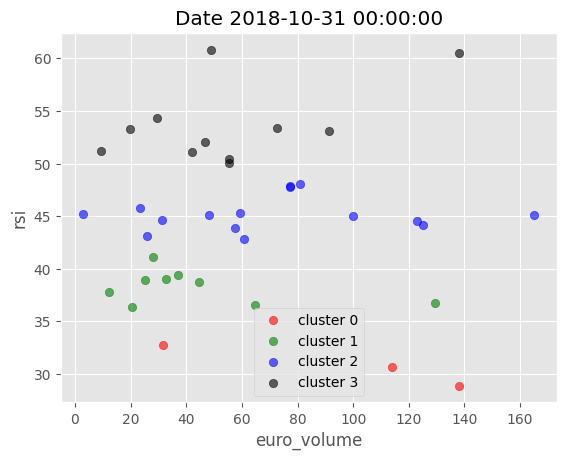

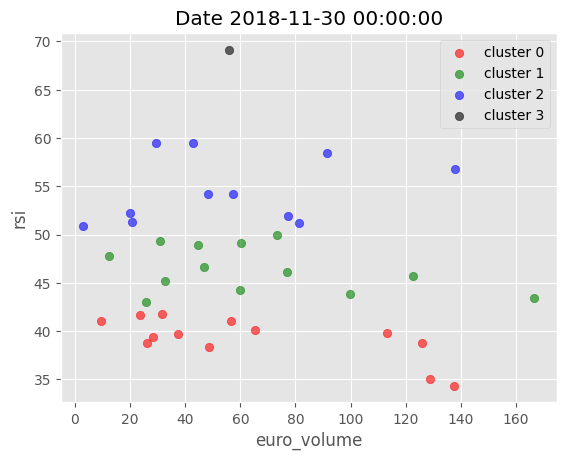

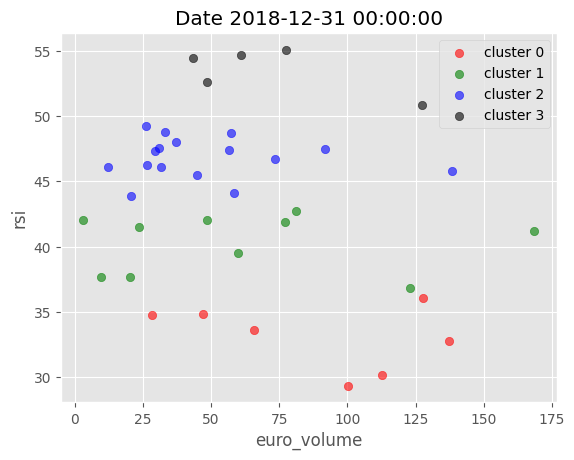

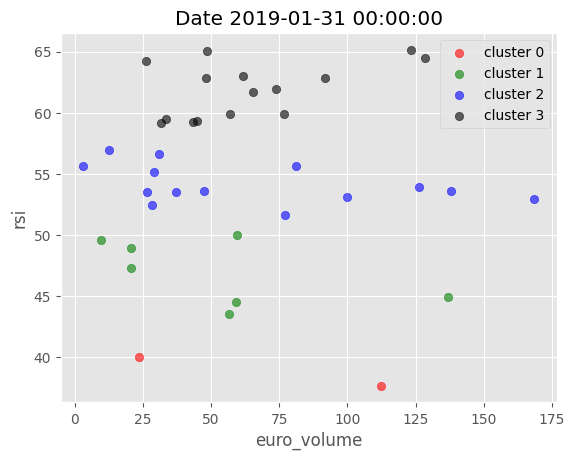

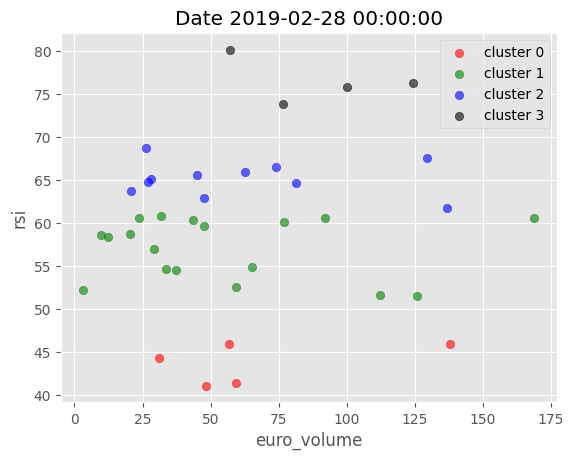

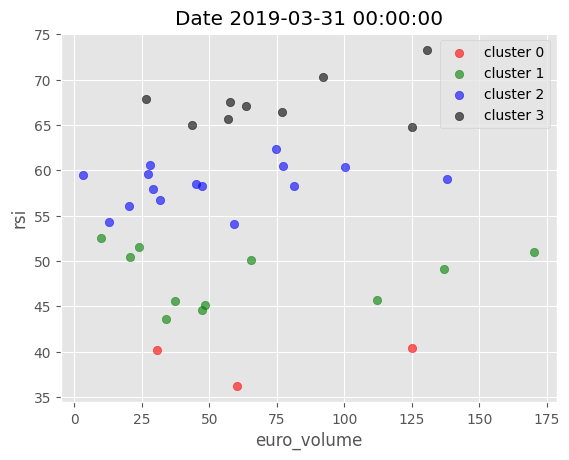

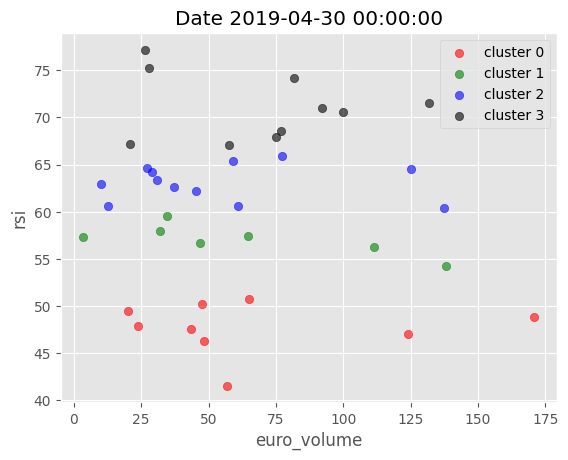

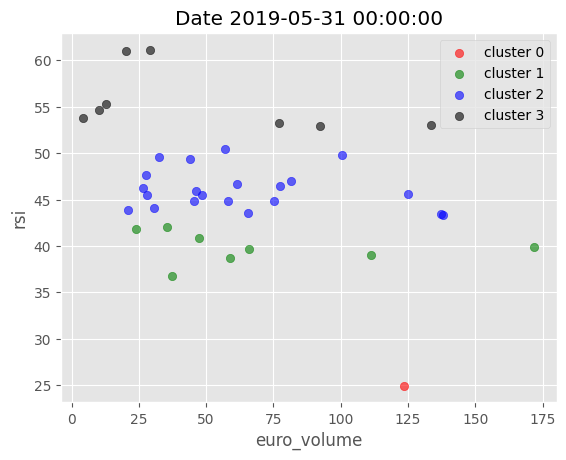

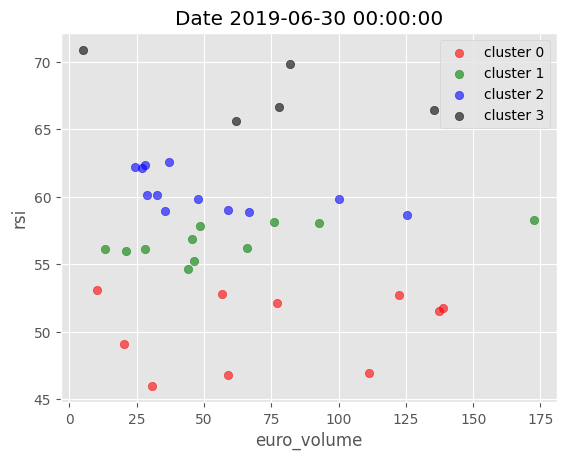

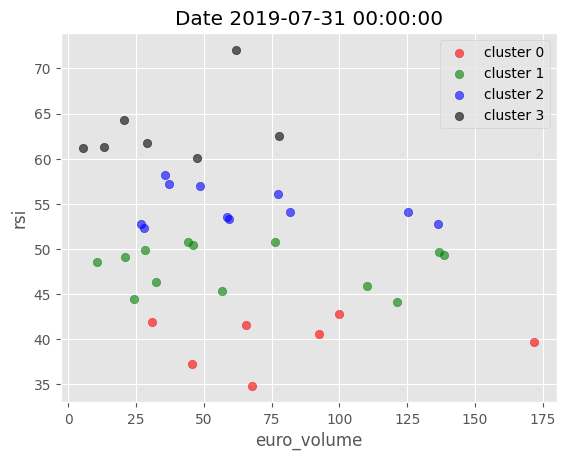

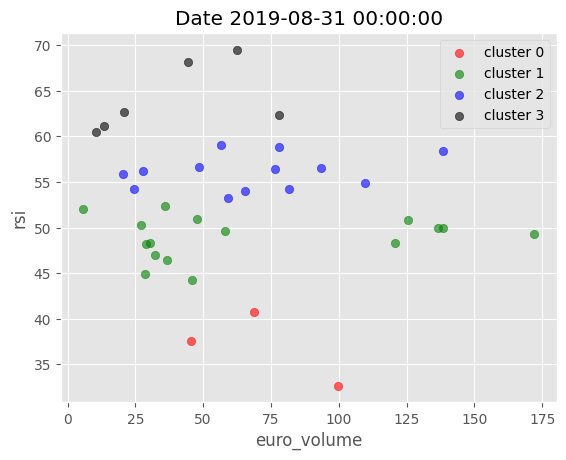

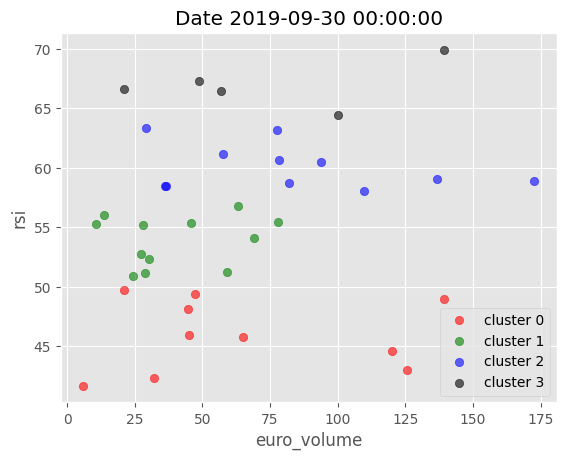

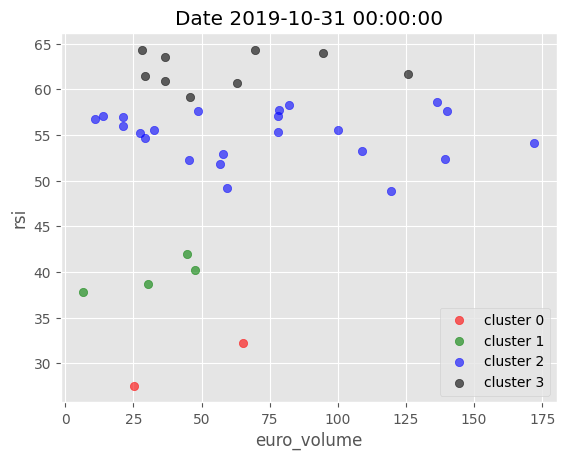

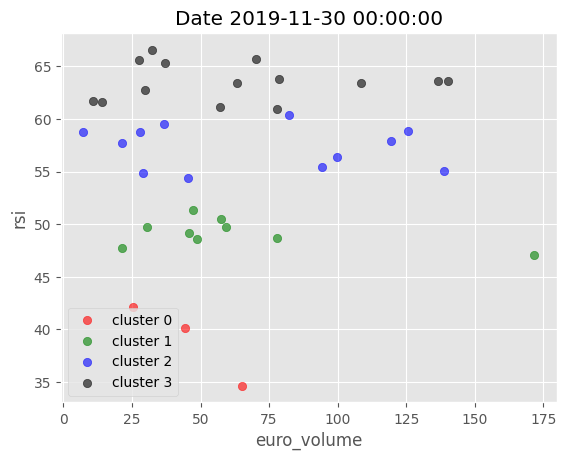

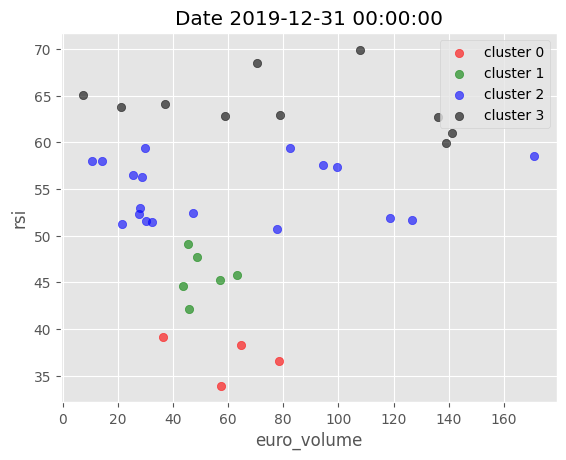

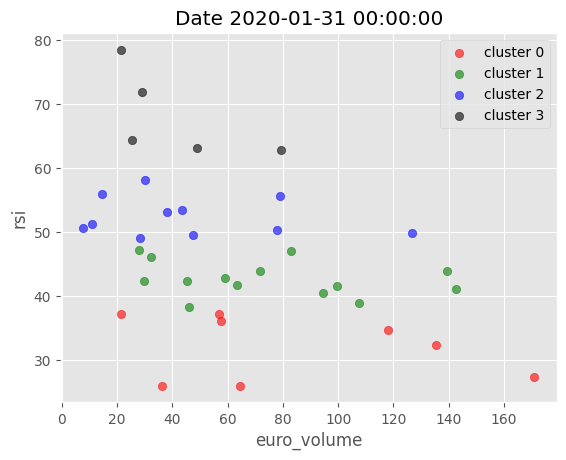

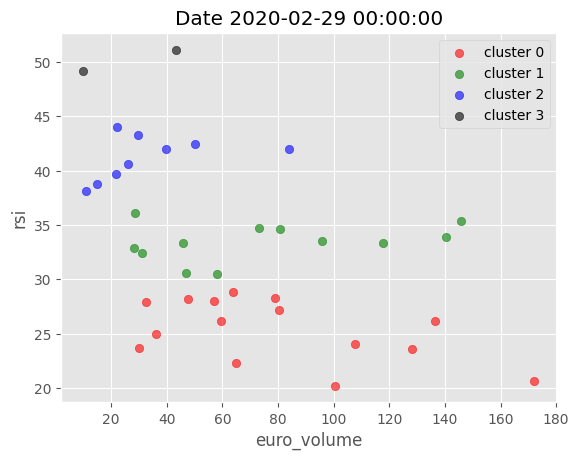

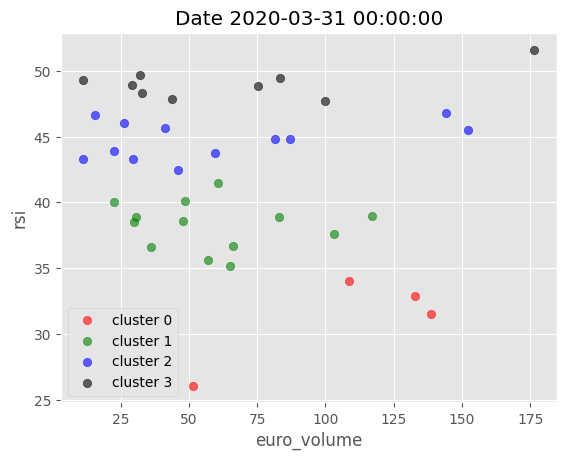

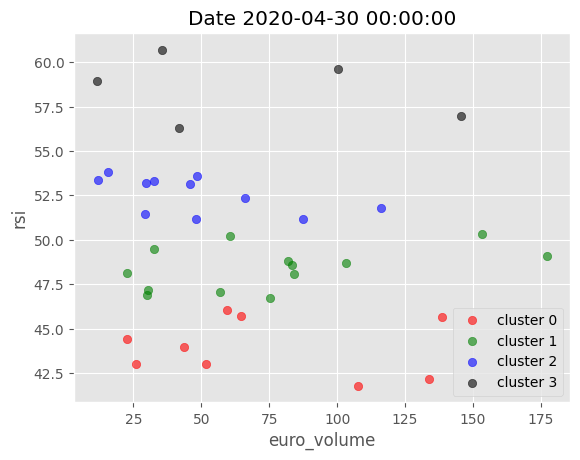

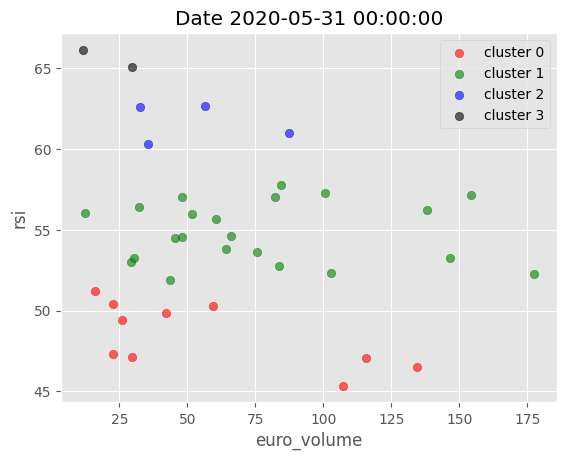

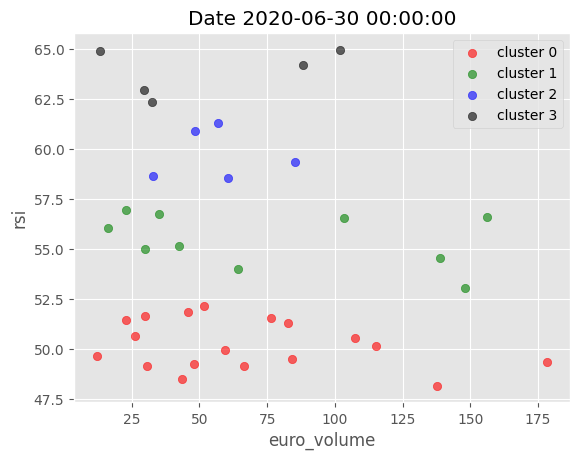

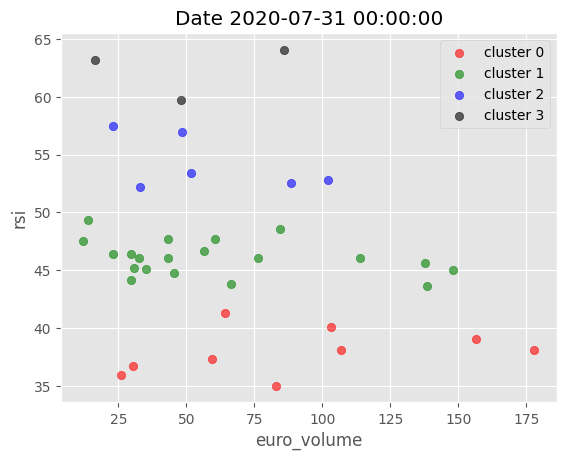

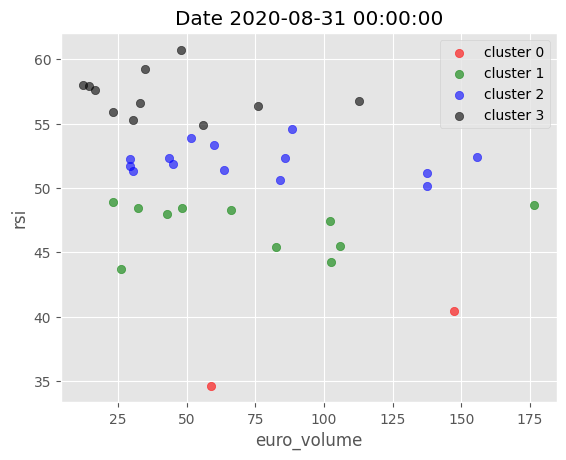

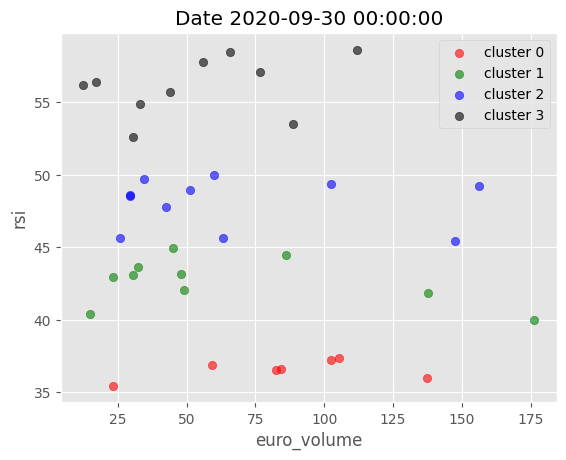

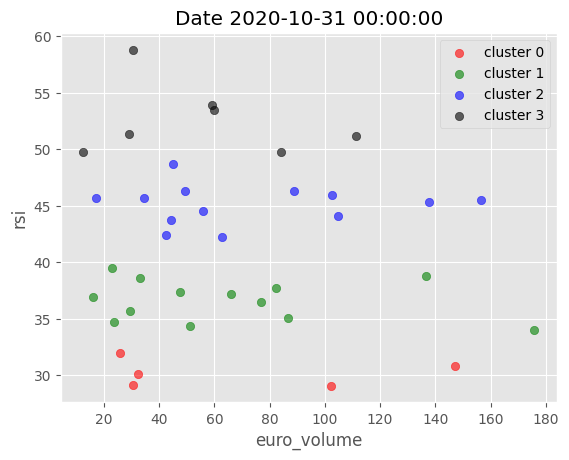

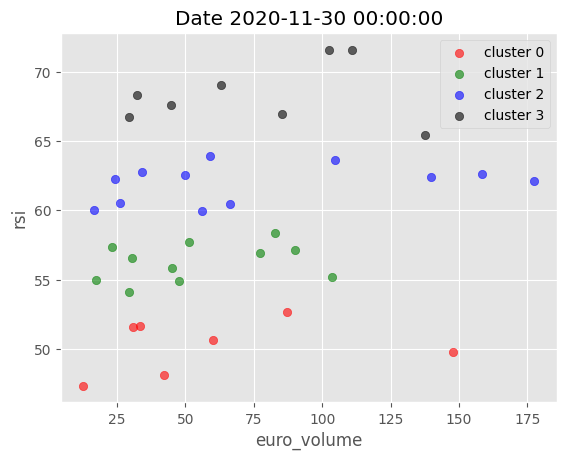

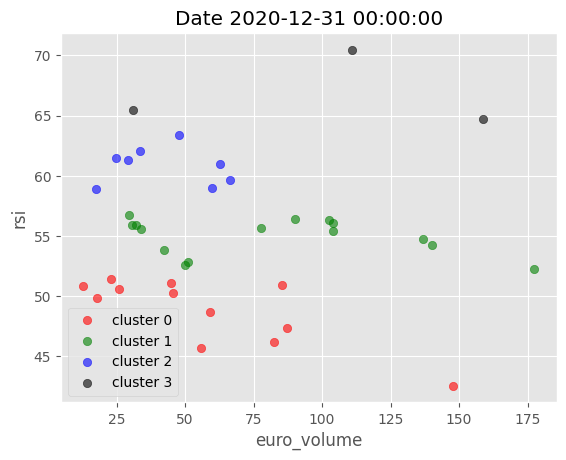

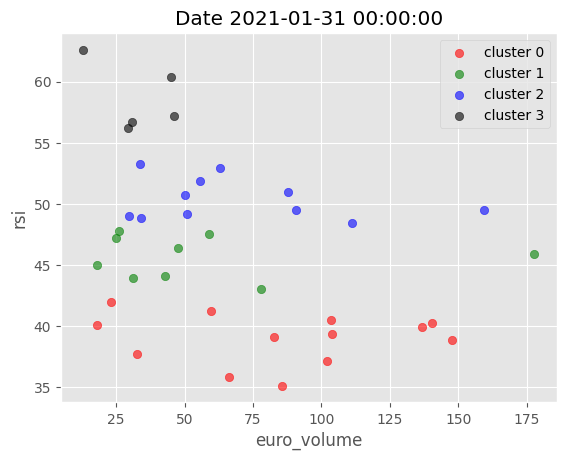

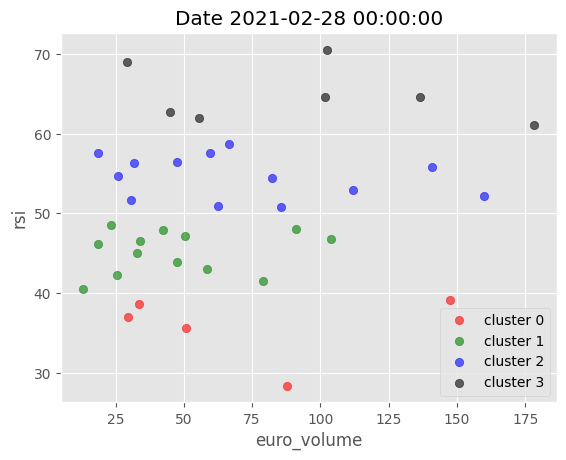

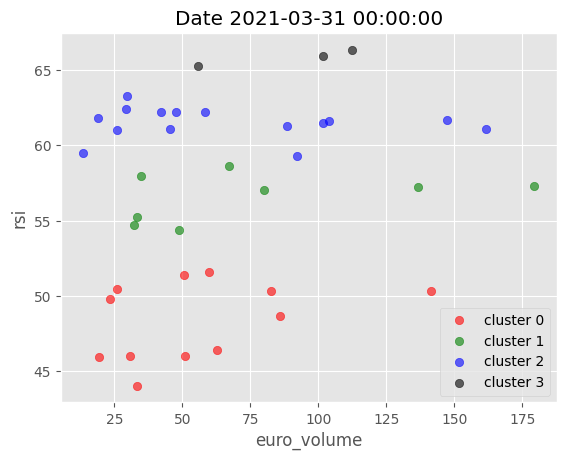

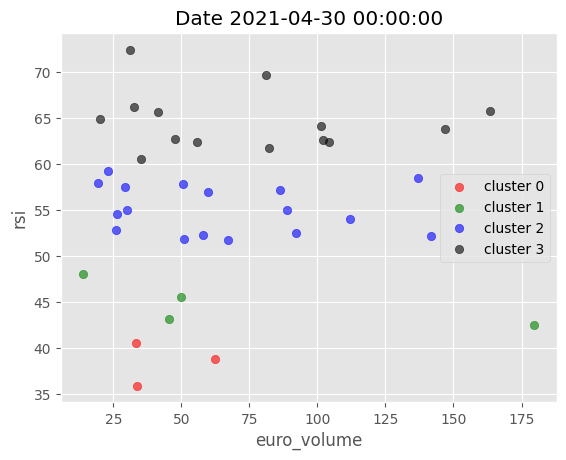

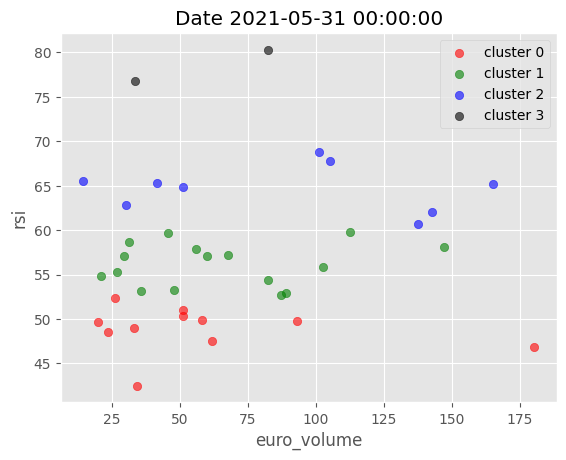

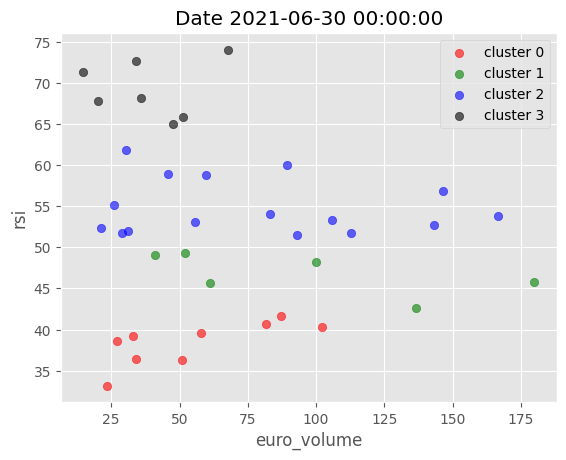

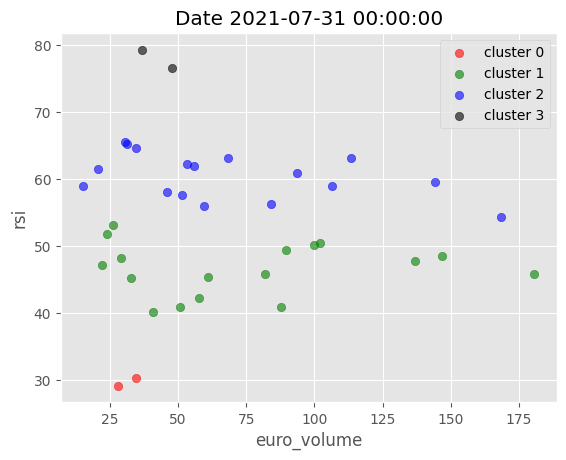

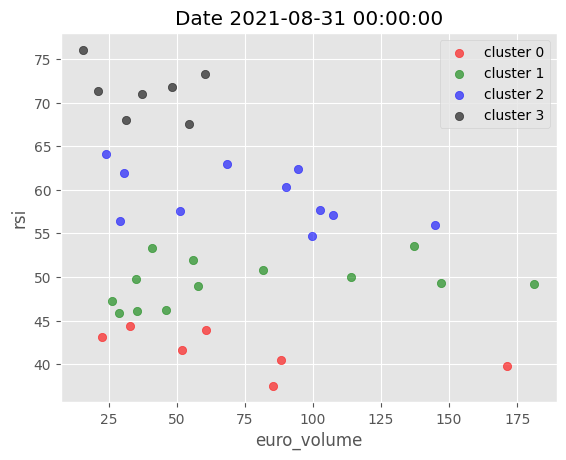

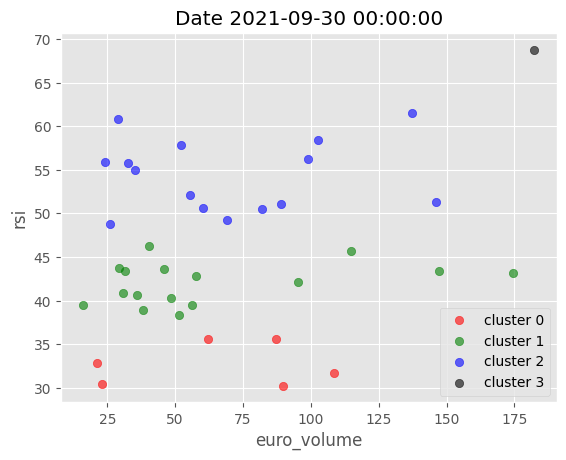

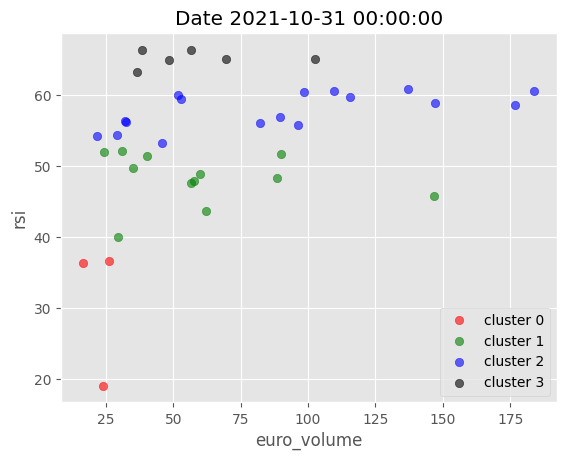

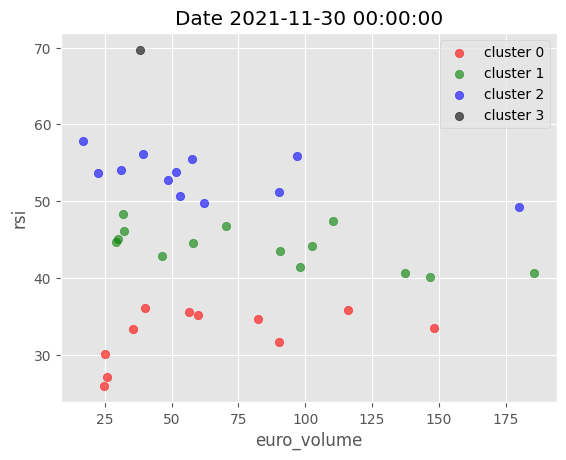

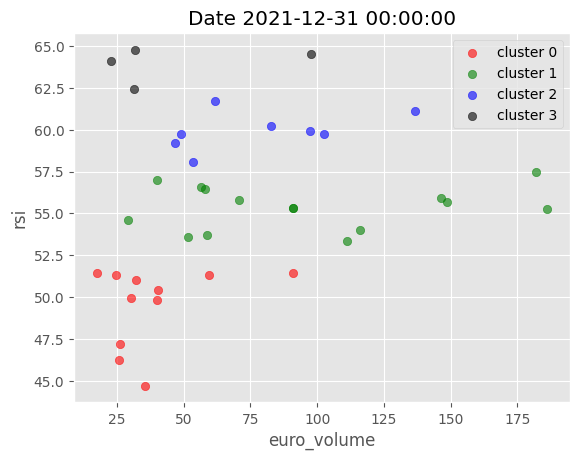

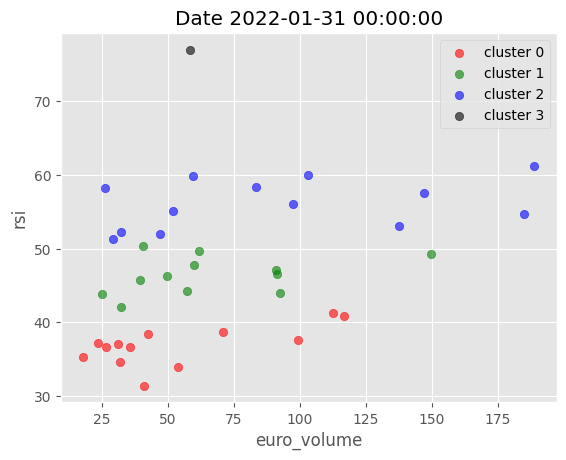

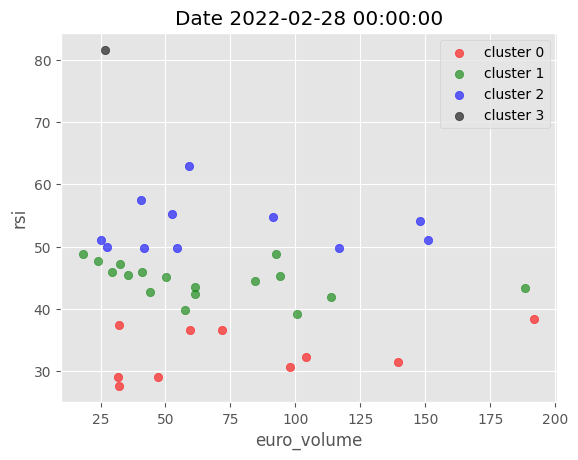

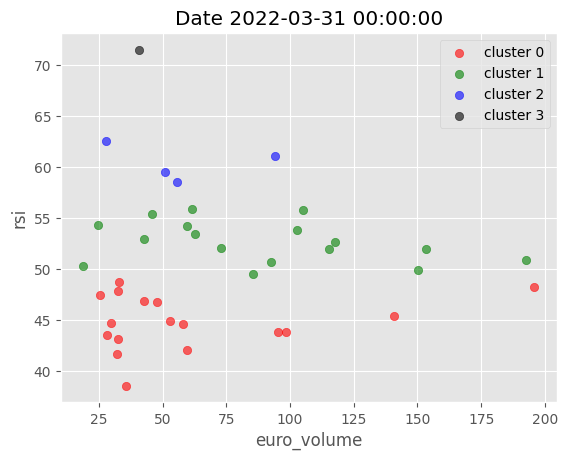

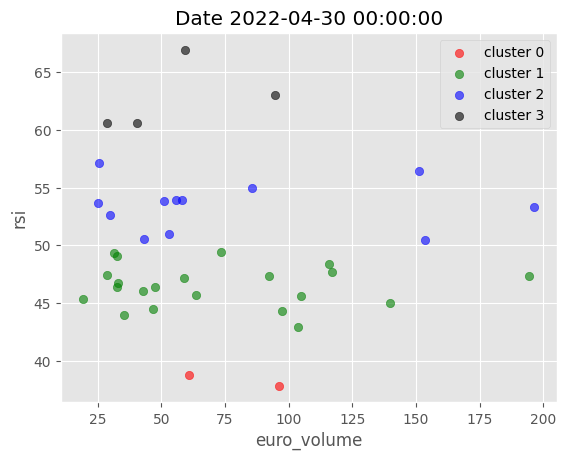

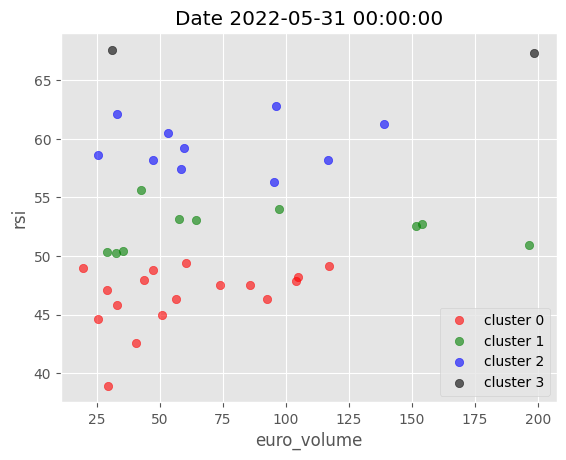

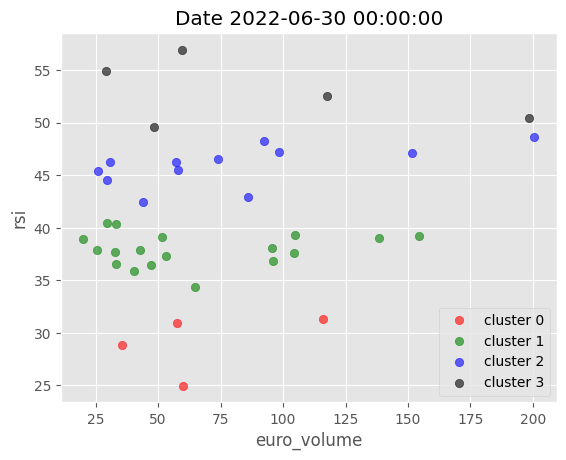

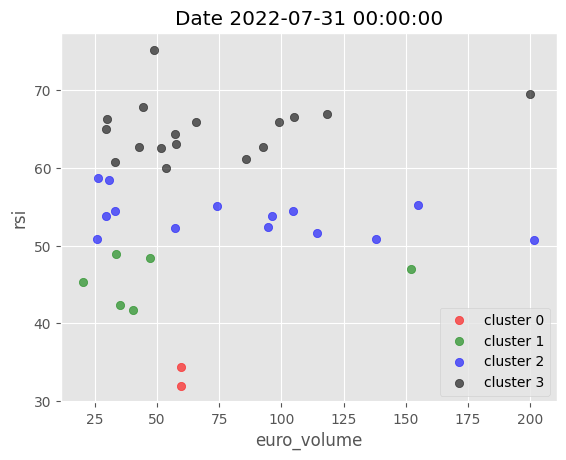

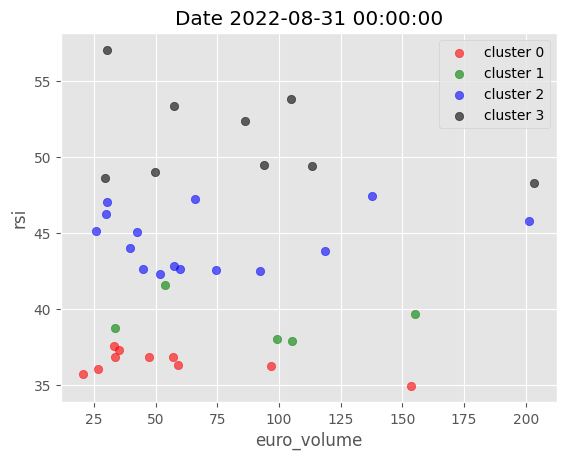

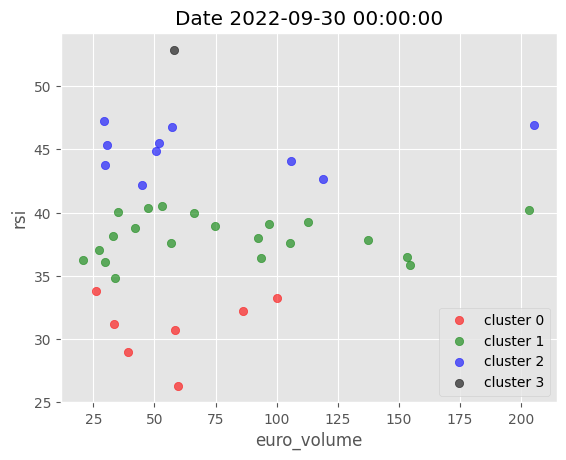

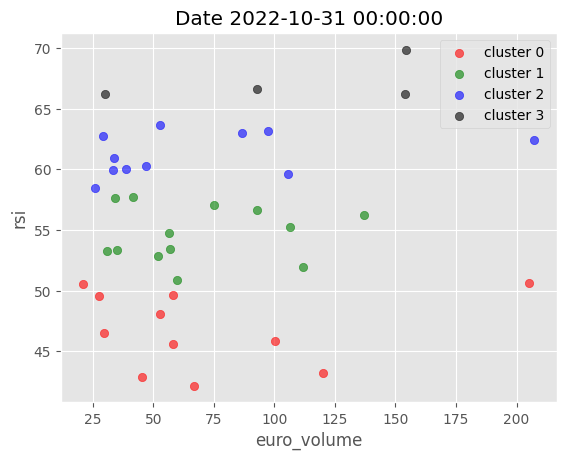

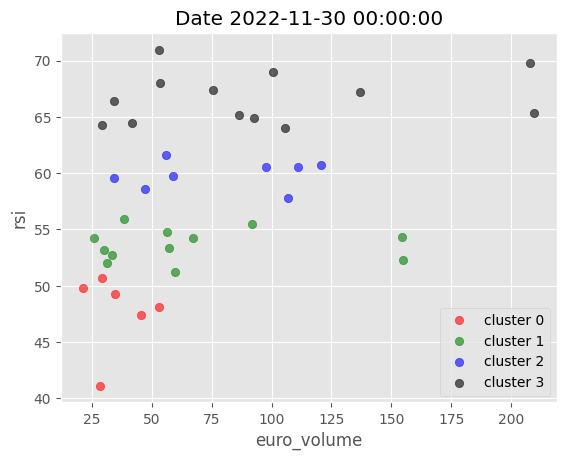

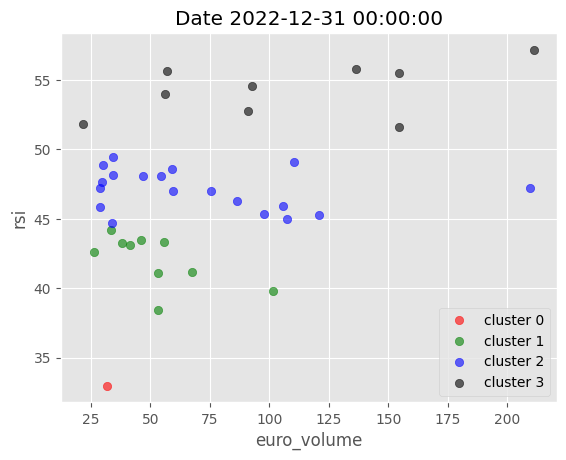

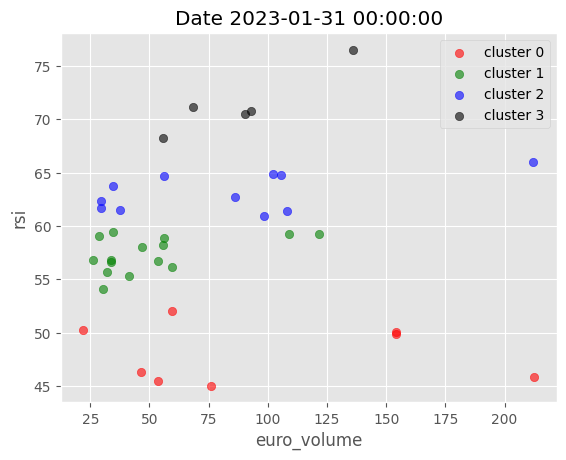

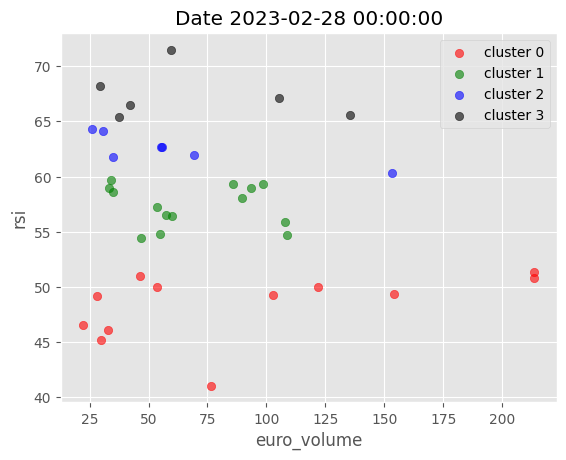

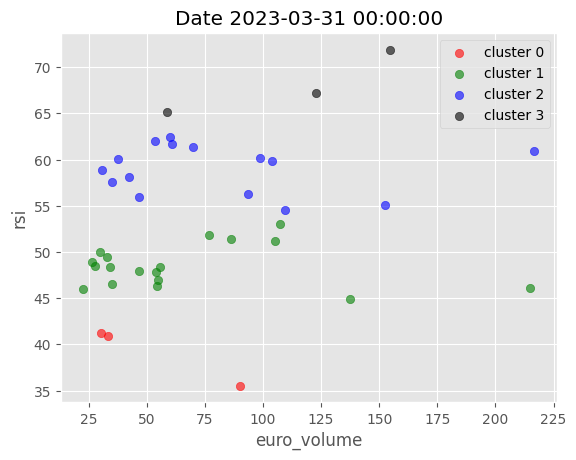

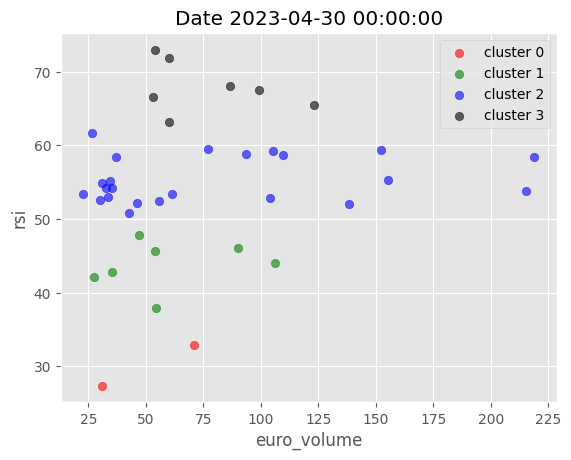

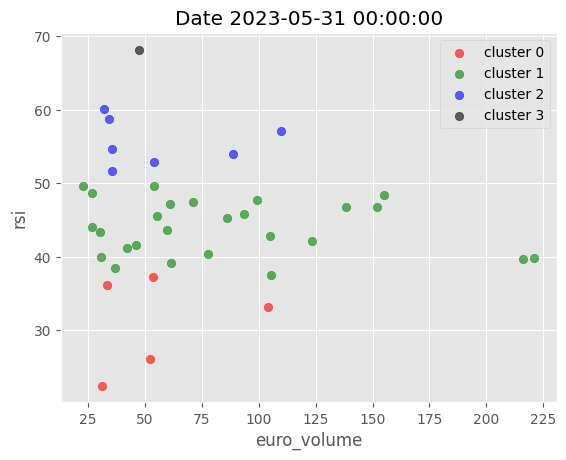

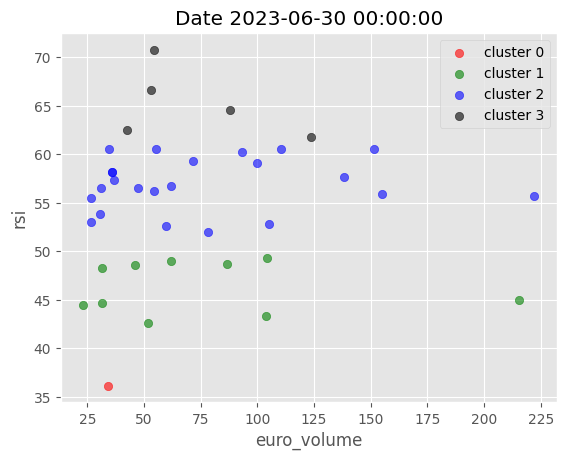

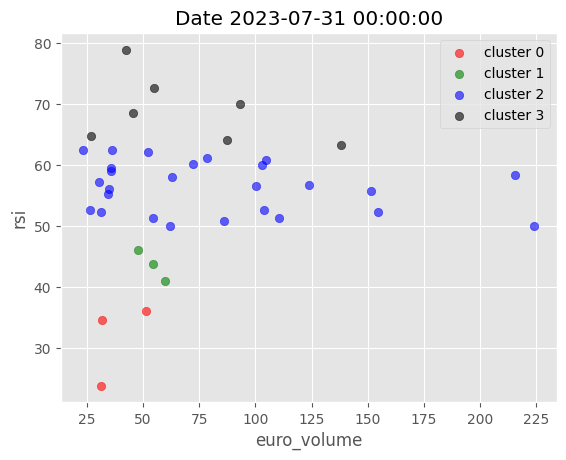

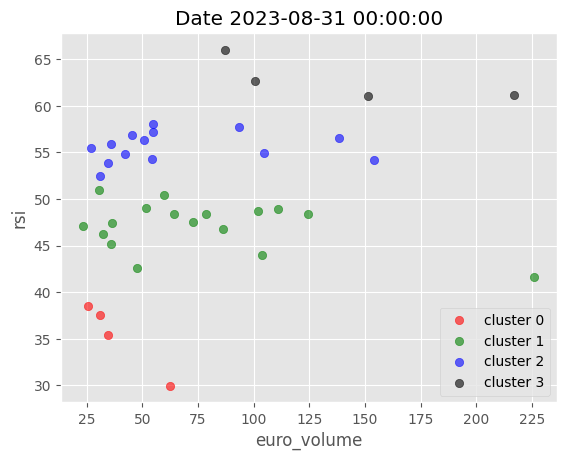

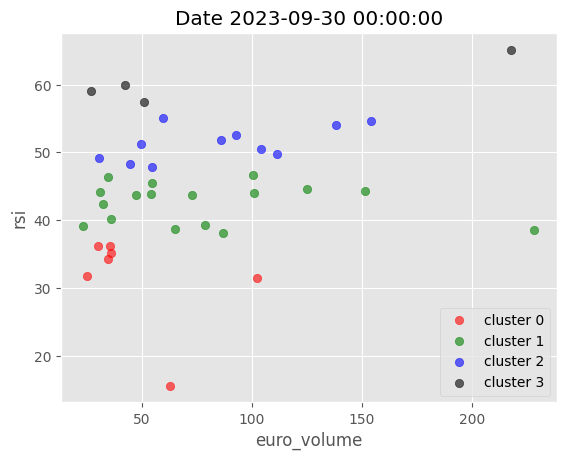

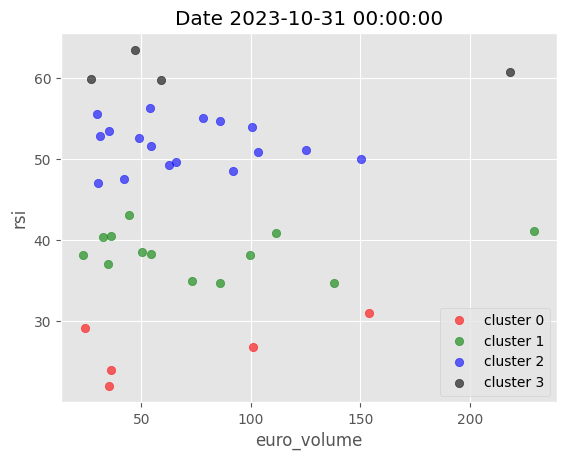

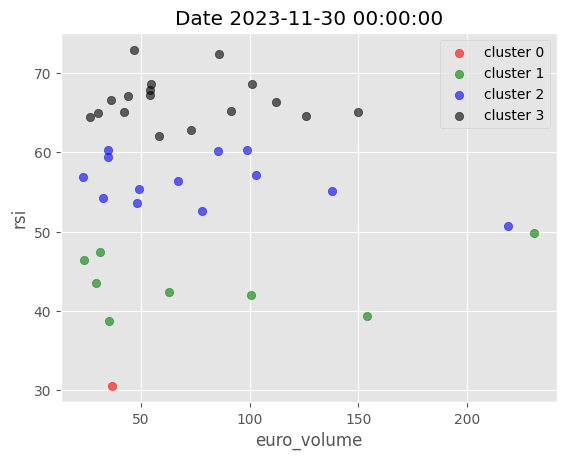

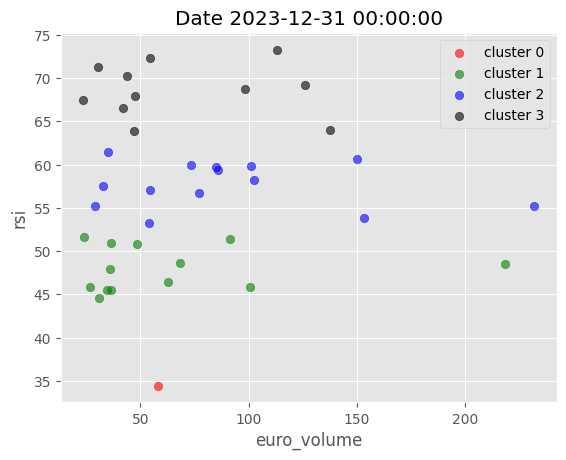

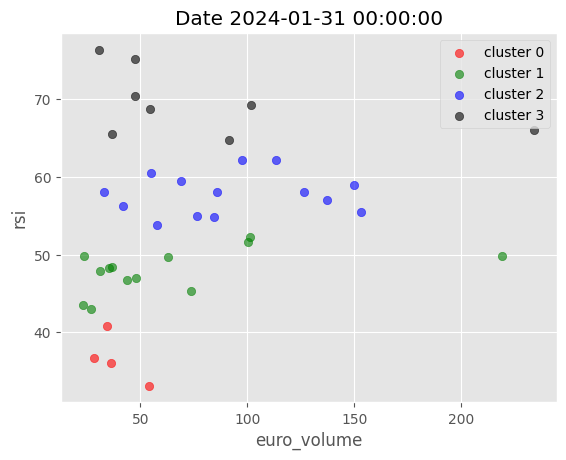

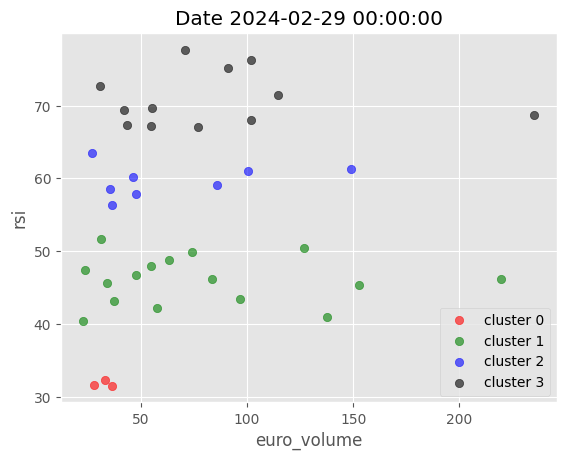

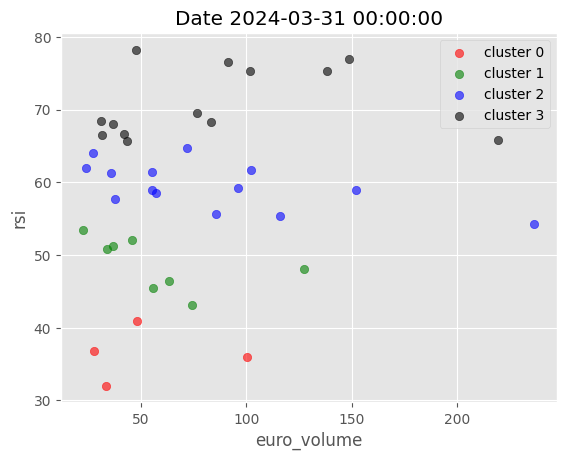

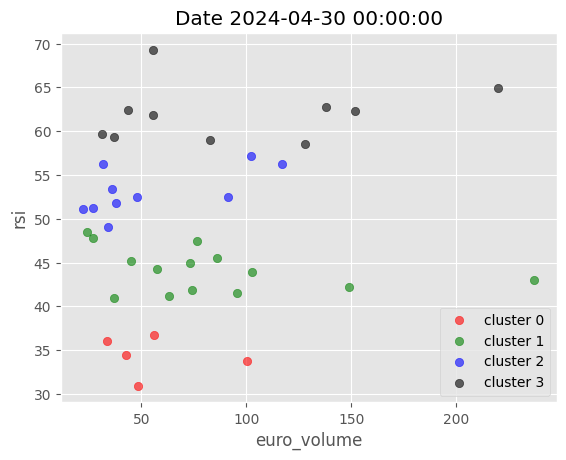

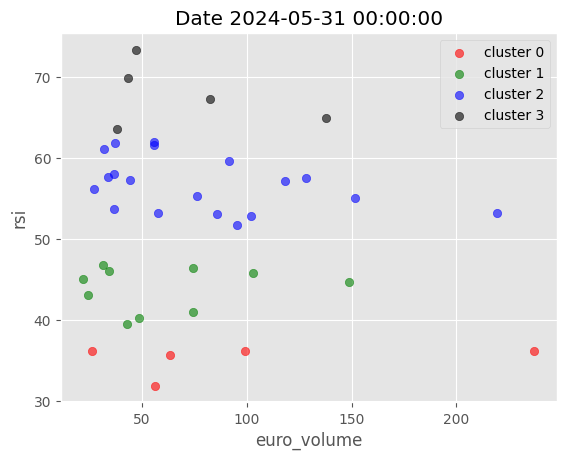

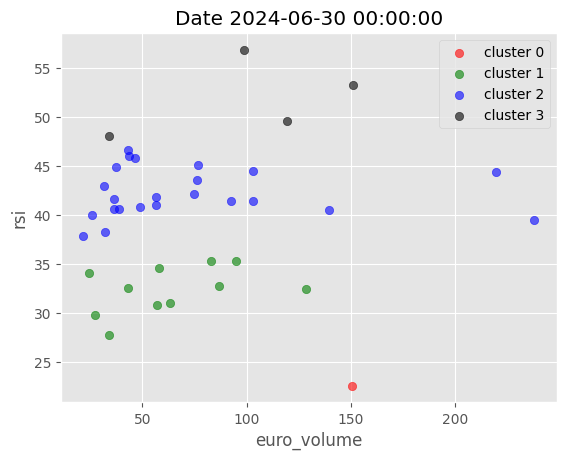

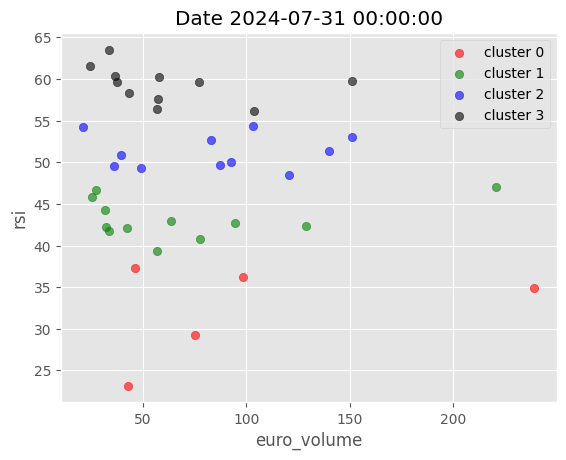

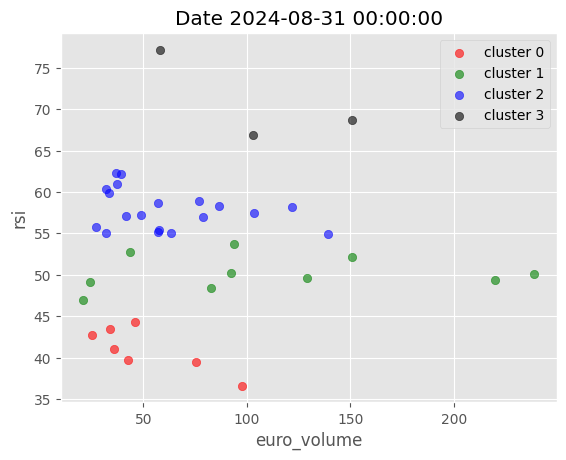

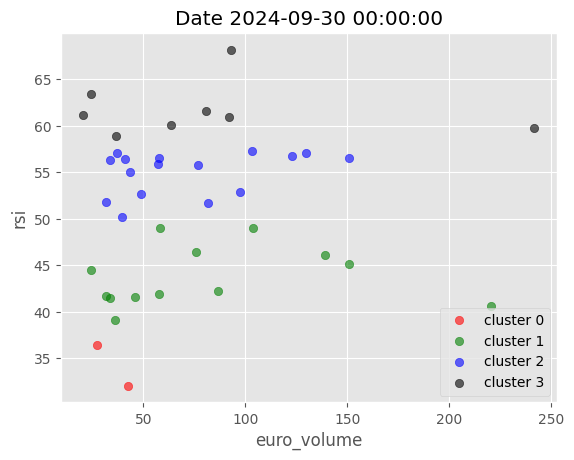

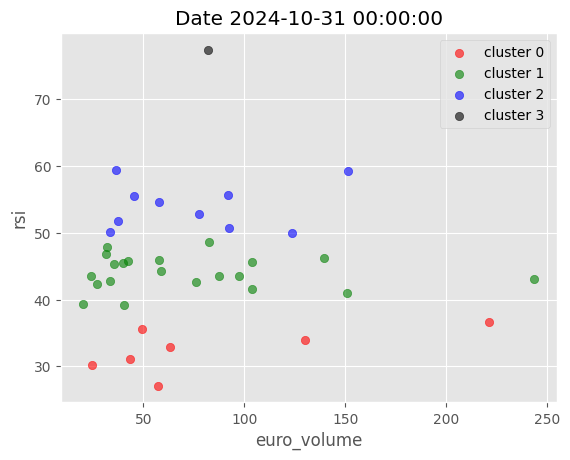

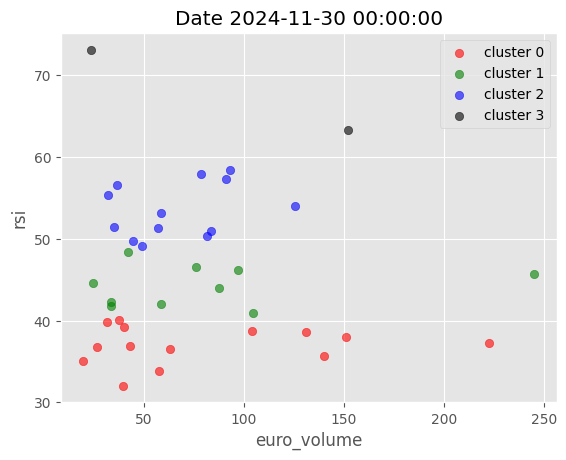

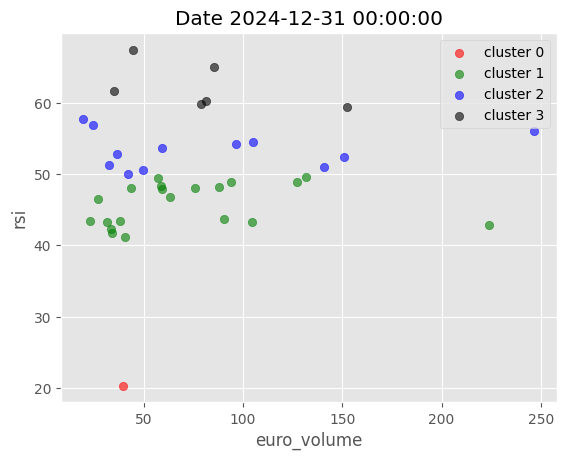

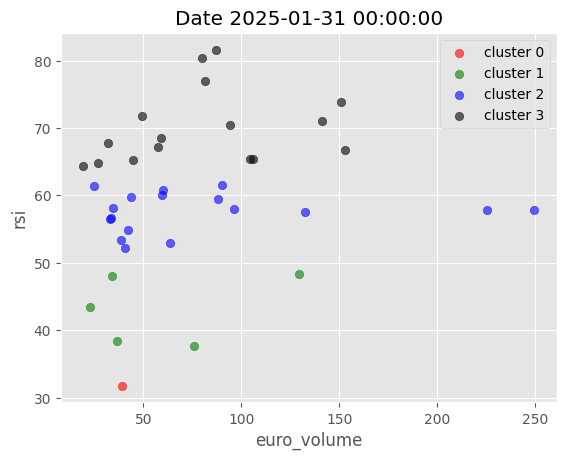

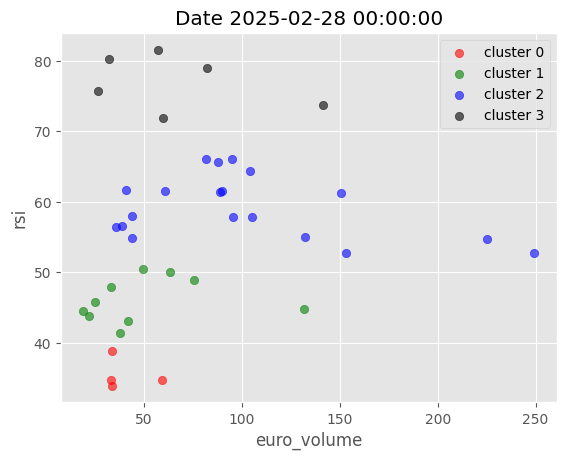

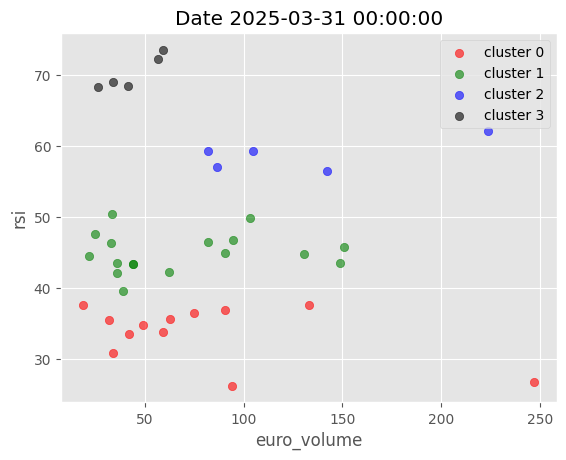

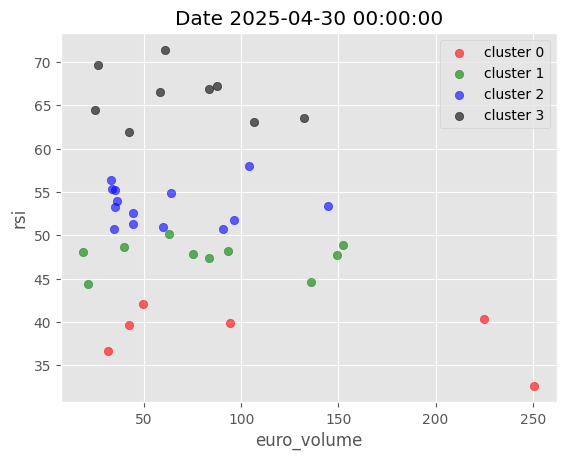

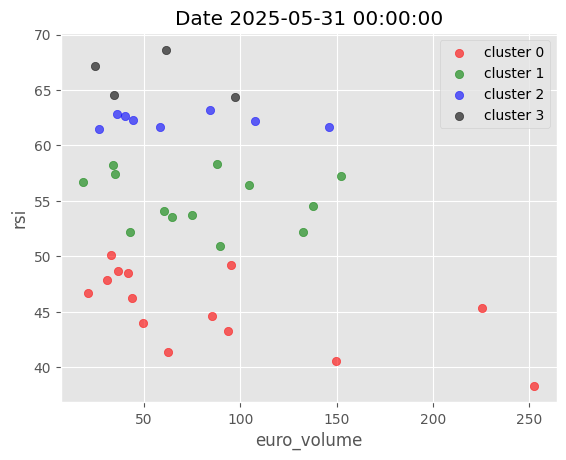

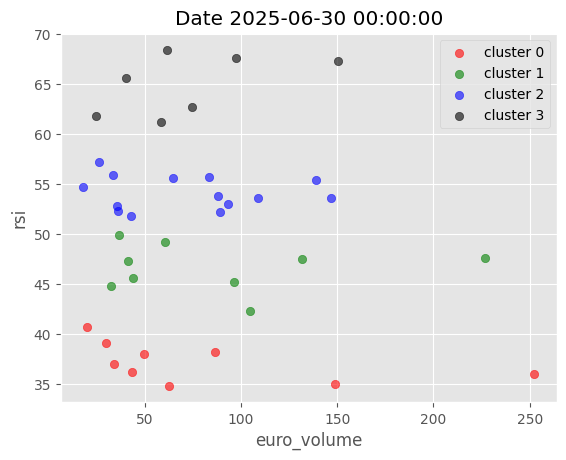

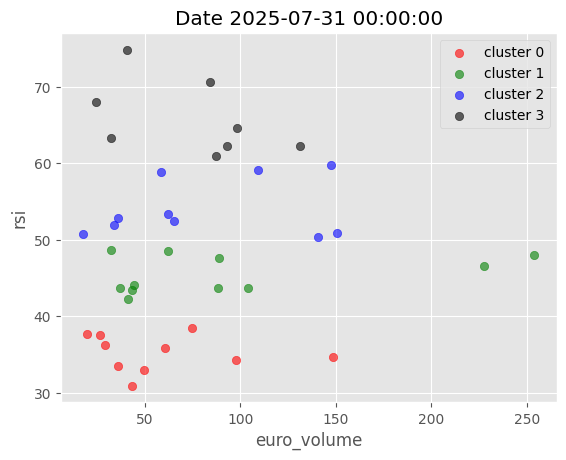

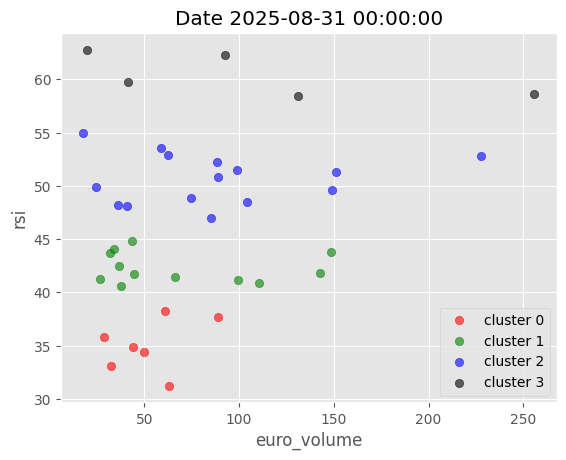

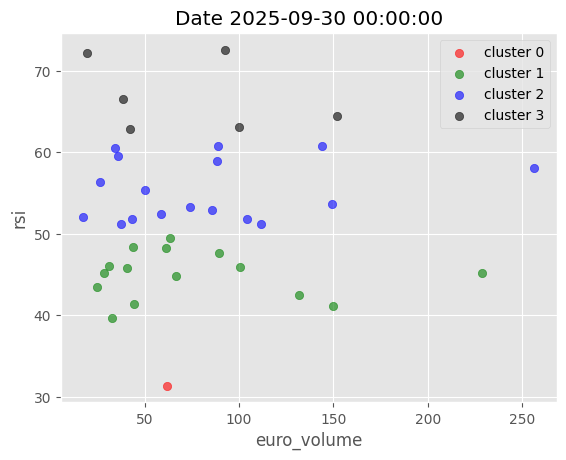

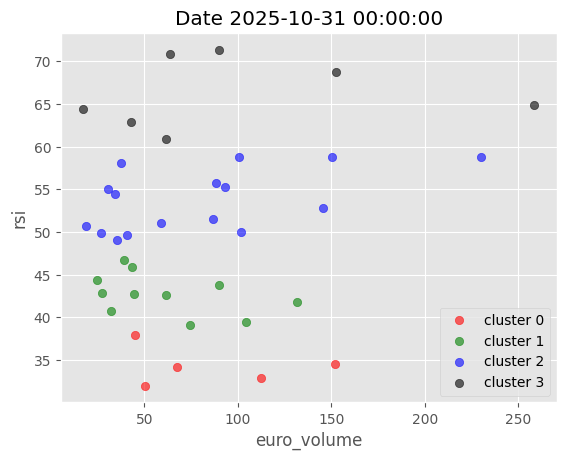

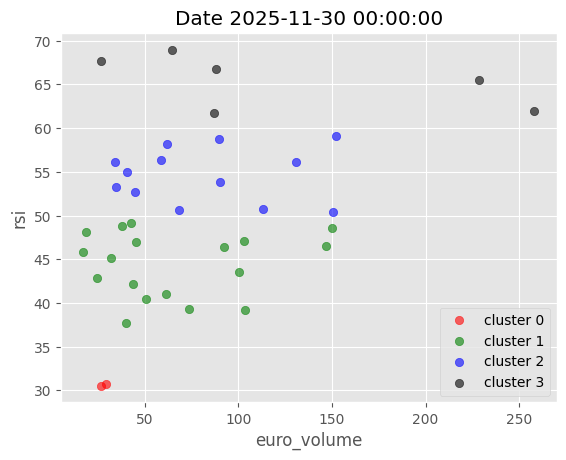

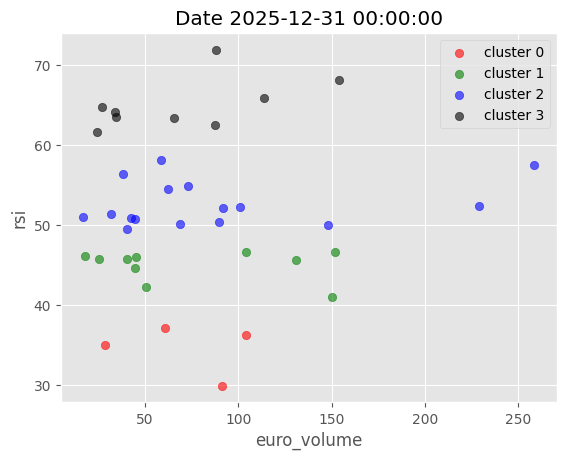

In [45]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')

def plot_clusters(data):
    cluster_0 = data[data['cluster'] == 0]
    cluster_1 = data[data['cluster'] == 1]
    cluster_2 = data[data['cluster'] == 2]
    cluster_3 = data[data['cluster'] == 3]
    
    plt.scatter(cluster_0.iloc[:, 0], cluster_0.iloc[:, 2], color='red', label='cluster 0', alpha=0.6)
    plt.scatter(cluster_1.iloc[:, 0], cluster_1.iloc[:, 2], color='green', label='cluster 1', alpha=0.6)
    plt.scatter(cluster_2.iloc[:, 0], cluster_2.iloc[:, 2], color='blue', label='cluster 2', alpha=0.6)
    plt.scatter(cluster_3.iloc[:, 0], cluster_3.iloc[:, 2], color='black', label='cluster 3', alpha=0.6)
    
    plt.xlabel(data.columns[0])  # Nom de la colonne X
    plt.ylabel(data.columns[2])  # Nom de la colonne Y (RSI)
    plt.legend()
    plt.show()

# Plot pour chaque date
for i in data.index.get_level_values('date').unique().tolist():
    g = data.xs(i, level=0)
    plt.title(f'Date {i}')
    plot_clusters(g)


## Prediction using Supervised ML

🚀 XGBOOST - Prédiction Returns

📊 Préparation des données...
   Données complètes : 4,114 lignes
   Features          : 16
   Target            : return_1m

📈 Statistiques return_1m :
   Moyenne : 2.57%
   Médiane : 0.89%
   Std     : 116.01%
   Min     : -69.30%
   Max     : 7423.03%

🔀 Split Train/Test...
   Train : 3,291 observations
   Test  : 823 observations

🔧 Entraînement XGBoost...

✅ XGBoost entraîné
   Meilleure itération : 198

📊 Évaluation des performances...

Métrique            Train         Test
----------------------------------------
MSE              0.000482     6.652068
RMSE             0.021962     2.579160
MAE              0.016955     0.126485
R²                 0.9261       0.0064

💡 Interprétation :
   ❌ R² Test = 0.0064 → Très faible pouvoir prédictif

📈 Feature Importance...

Top 10 features :
   rsi                  : 0.3376
   macd                 : 0.2740
   return_2m            : 0.0616
   cluster              : 0.0468
   Mkt-RF               : 0.0396
   

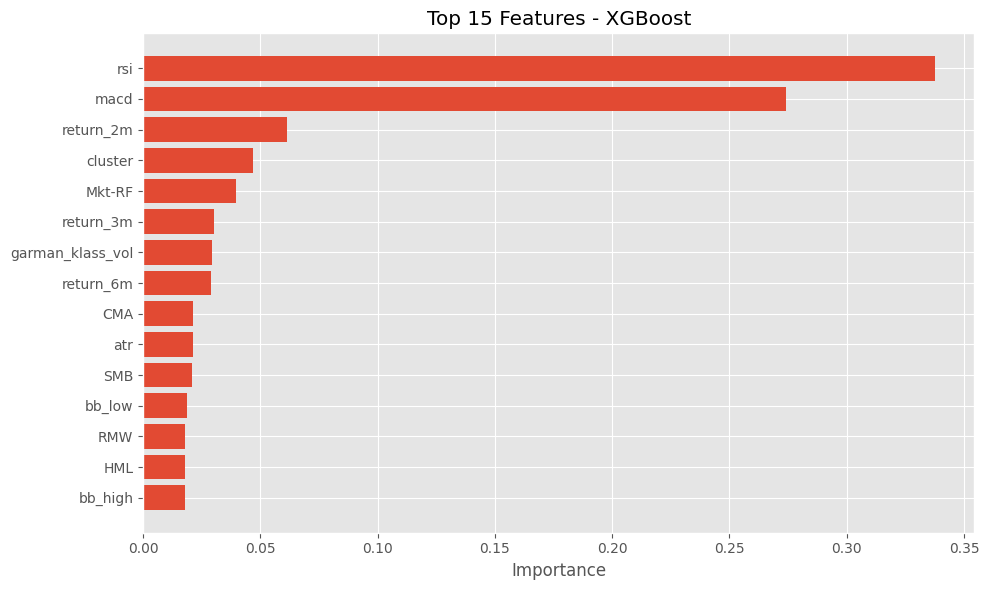


💾 Génération des prédictions...

📊 Statistiques prédictions :
   Nombre  : 4,114
   Moyenne : 0.87%
   Médiane : 1.02%
   Std     : 7.53%
   Min     : -43.15%
   Max     : 34.07%

📈 Distribution prédictions :
   Négatives (< 0%)   : 1,798 (43.7%)
   Faibles (0-1%)     : 254 (6.2%)
   Moyennes (1-2%)    : 196 (4.8%)
   Fortes (> 2%)      : 1,866 (45.4%)

🎯 Analyse par Cluster...

Prédictions moyennes par cluster :
         predicted_return_xgb_count  predicted_return_xgb_mean  \
cluster                                                          
0                               681                    -0.0715   
1                              1312                    -0.0185   
2                              1413                     0.0333   
3                               708                     0.0872   

         predicted_return_xgb_std  return_1m_mean  
cluster                                            
0                          0.0677         -0.0704  
1                          0.

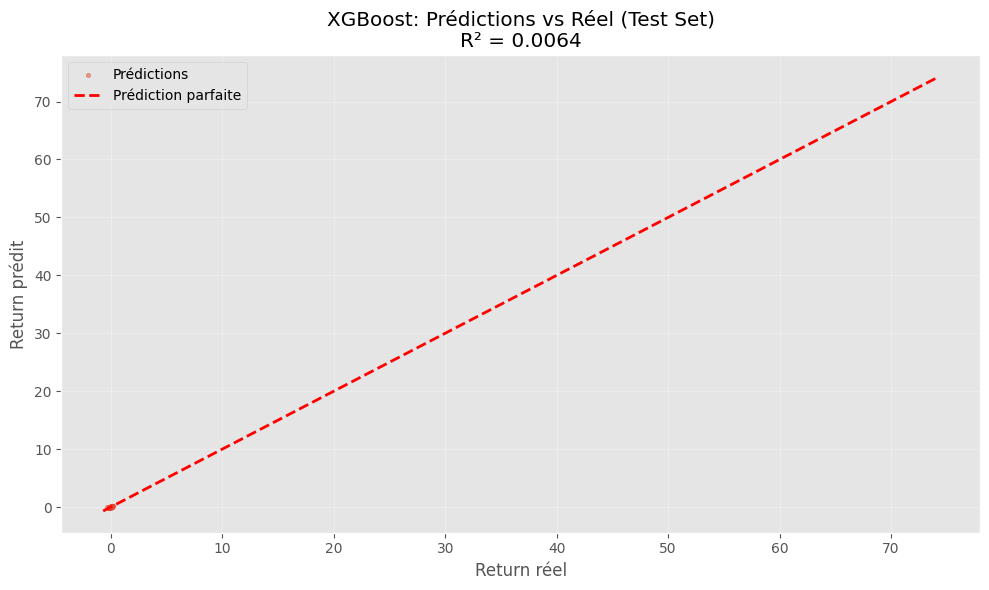


✅ XGBOOST TERMINÉ

Variables disponibles :
   - xgb_model          : Modèle entraîné
   - ml_data            : Données avec 'predicted_return_xgb'
   - feature_importance : Importance des features

Prochaine étape : Filtrage pour optimisation portefeuille


In [52]:
"""
=============================================================================
XGBOOST - Prédiction Returns Actions (Cluster 3)
=============================================================================

Objectif :
    - Filtrer actions Cluster 3 (momentum RSI ~70)
    - Prédire return_1m (regression)
    - Utiliser pour optimisation portefeuille
    
Données :
    - Input  : data (DataFrame avec MultiIndex date/ticker)
    - Output : Modèle XGBoost entraîné
"""

import numpy as np
import pandas as pd
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print("="*70)
print("🚀 XGBOOST - Prédiction Returns")
print("="*70)


# =============================================================================
# 1. PRÉPARATION DES DONNÉES
# =============================================================================

print("\n📊 Préparation des données...")

# Features pour XGBoost
feature_cols = [
    # Indicateurs techniques
    'rsi', 'macd', 'bb_low', 'bb_high', 'atr',
    
    # Volume
    'euro_volume', 'garman_klass_vol',
    
    # Returns passés
    'return_2m', 'return_3m', 'return_6m',
    
    # Fama-French 5 facteurs
    'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA',
    
    # Cluster (important!)
    'cluster'
]

# Target : Return 1 mois suivant
target_col = 'return_1m'

# Supprimer NaN
ml_data = data[feature_cols + [target_col]].dropna().copy()

print(f"   Données complètes : {ml_data.shape[0]:,} lignes")
print(f"   Features          : {len(feature_cols)}")
print(f"   Target            : {target_col}")

# Statistiques target
print(f"\n📈 Statistiques {target_col} :")
print(f"   Moyenne : {ml_data[target_col].mean()*100:.2f}%")
print(f"   Médiane : {ml_data[target_col].median()*100:.2f}%")
print(f"   Std     : {ml_data[target_col].std()*100:.2f}%")
print(f"   Min     : {ml_data[target_col].min()*100:.2f}%")
print(f"   Max     : {ml_data[target_col].max()*100:.2f}%")


# =============================================================================
# 2. TRAIN/TEST SPLIT (80/20)
# =============================================================================

print("\n🔀 Split Train/Test...")

X = ml_data[feature_cols]
y = ml_data[target_col]

# Split temporel (pas shuffle pour time series)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=0, 
    shuffle=False  # Important pour time series
)

print(f"   Train : {X_train.shape[0]:,} observations")
print(f"   Test  : {X_test.shape[0]:,} observations")


# =============================================================================
# 3. MODÈLE XGBOOST
# =============================================================================

print("\n🔧 Entraînement XGBoost...\n")

# Hyperparamètres
xgb_model = XGBRegressor(
    n_estimators=200,          # Nombre d'arbres
    max_depth=5,               # Profondeur max
    learning_rate=0.05,        # Taux d'apprentissage
    subsample=0.8,             # % données par arbre
    colsample_bytree=0.8,      # % features par arbre
    random_state=0,
    n_jobs=-1,                 # Tous les cores CPU
    enable_categorical=True,   # Pour gérer 'cluster' comme catégorie
    early_stopping_rounds=20,  # Early stopping
    eval_metric='rmse'         # Métrique pour early stopping
)

# Entraînement
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)

print(f"✅ XGBoost entraîné")
print(f"   Meilleure itération : {xgb_model.best_iteration}")


# =============================================================================
# 4. ÉVALUATION
# =============================================================================

print("\n📊 Évaluation des performances...\n")

# Prédictions
y_pred_train = xgb_model.predict(X_train)
y_pred_test = xgb_model.predict(X_test)

# Métriques Train
mse_train = mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)
mae_train = mean_absolute_error(y_train, y_pred_train)

# Métriques Test
mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)

# Affichage
print(f"{'Métrique':<12} {'Train':>12} {'Test':>12}")
print(f"{'-'*40}")
print(f"{'MSE':<12} {mse_train:>12.6f} {mse_test:>12.6f}")
print(f"{'RMSE':<12} {np.sqrt(mse_train):>12.6f} {np.sqrt(mse_test):>12.6f}")
print(f"{'MAE':<12} {mae_train:>12.6f} {mae_test:>12.6f}")
print(f"{'R²':<12} {r2_train:>12.4f} {r2_test:>12.4f}")

# Interprétation R²
print(f"\n💡 Interprétation :")
if r2_test > 0.05:
    print(f"   ✅ R² Test = {r2_test:.4f} → Le modèle capture {r2_test*100:.2f}% de la variance")
elif r2_test > 0.01:
    print(f"   ⚠️ R² Test = {r2_test:.4f} → Capture faible ({r2_test*100:.2f}%)")
else:
    print(f"   ❌ R² Test = {r2_test:.4f} → Très faible pouvoir prédictif")


# =============================================================================
# 5. FEATURE IMPORTANCE
# =============================================================================

print("\n📈 Feature Importance...\n")

# Créer DataFrame
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

# Top 10
print("Top 10 features :")
for i, row in feature_importance.head(10).iterrows():
    print(f"   {row['feature']:<20} : {row['importance']:.4f}")

# Graphique
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'].head(15), 
         feature_importance['importance'].head(15))
plt.xlabel('Importance')
plt.title('Top 15 Features - XGBoost')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


# =============================================================================
# 6. PRÉDICTIONS SUR ml_data (pour analyse)
# =============================================================================

print("\n💾 Génération des prédictions...\n")

# Prédire sur ml_data (données nettoyées)
ml_data['predicted_return_xgb'] = xgb_model.predict(ml_data[feature_cols])

# Statistiques prédictions
preds = ml_data['predicted_return_xgb']
print(f"📊 Statistiques prédictions :")
print(f"   Nombre  : {len(preds):,}")
print(f"   Moyenne : {preds.mean()*100:.2f}%")
print(f"   Médiane : {preds.median()*100:.2f}%")
print(f"   Std     : {preds.std()*100:.2f}%")
print(f"   Min     : {preds.min()*100:.2f}%")
print(f"   Max     : {preds.max()*100:.2f}%")

# Distribution
print(f"\n📈 Distribution prédictions :")
print(f"   Négatives (< 0%)   : {(preds < 0).sum():,} ({(preds < 0).mean()*100:.1f}%)")
print(f"   Faibles (0-1%)     : {((preds >= 0) & (preds < 0.01)).sum():,} ({((preds >= 0) & (preds < 0.01)).mean()*100:.1f}%)")
print(f"   Moyennes (1-2%)    : {((preds >= 0.01) & (preds < 0.02)).sum():,} ({((preds >= 0.01) & (preds < 0.02)).mean()*100:.1f}%)")
print(f"   Fortes (> 2%)      : {(preds >= 0.02).sum():,} ({(preds >= 0.02).mean()*100:.1f}%)")


# =============================================================================
# 7. ANALYSE PAR CLUSTER
# =============================================================================

print("\n🎯 Analyse par Cluster...\n")

# Grouper par cluster
cluster_analysis = ml_data.groupby('cluster').agg({
    'predicted_return_xgb': ['count', 'mean', 'std'],
    target_col: 'mean'
}).round(4)

cluster_analysis.columns = ['_'.join(col).strip() for col in cluster_analysis.columns]

print("Prédictions moyennes par cluster :")
print(cluster_analysis)

# Focus sur Cluster 3 (momentum)
if 3 in ml_data['cluster'].unique():
    cluster3 = ml_data[ml_data['cluster'] == 3]
    cluster3_pred = cluster3['predicted_return_xgb']
    
    print(f"\n💡 Cluster 3 (Momentum) :")
    print(f"   Observations        : {len(cluster3_pred):,}")
    print(f"   Return prédit moyen : {cluster3_pred.mean()*100:.2f}%")
    print(f"   Return réel moyen   : {cluster3[target_col].mean()*100:.2f}%")
    print(f"   Prédictions > 0%    : {(cluster3_pred > 0).sum():,} ({(cluster3_pred > 0).mean()*100:.1f}%)")
    print(f"   Prédictions > 1%    : {(cluster3_pred > 0.01).sum():,} ({(cluster3_pred > 0.01).mean()*100:.1f}%)")
    print(f"   Prédictions > 2%    : {(cluster3_pred > 0.02).sum():,} ({(cluster3_pred > 0.02).mean()*100:.1f}%)")


# =============================================================================
# 8. GRAPHIQUE : PRÉDICTIONS VS RÉEL
# =============================================================================

print("\n📊 Génération graphique Pred vs Réel...")

plt.figure(figsize=(10, 6))

# Scatter plot (échantillon 10% pour lisibilité)
sample_size = int(0.1 * len(y_test))
sample_idx = np.random.choice(len(y_test), sample_size, replace=False)

plt.scatter(
    y_test.iloc[sample_idx], 
    y_pred_test[sample_idx],
    alpha=0.5,
    s=10,
    label='Prédictions'
)

# Ligne identité
max_val = max(y_test.max(), y_pred_test.max())
min_val = min(y_test.min(), y_pred_test.min())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Prédiction parfaite')

plt.xlabel('Return réel')
plt.ylabel('Return prédit')
plt.title(f'XGBoost: Prédictions vs Réel (Test Set)\nR² = {r2_test:.4f}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# =============================================================================
# FIN
# =============================================================================

print("\n" + "="*70)
print("✅ XGBOOST TERMINÉ")
print("="*70)
print(f"\nVariables disponibles :")
print(f"   - xgb_model          : Modèle entraîné")
print(f"   - ml_data            : Données avec 'predicted_return_xgb'")
print(f"   - feature_importance : Importance des features")
print(f"\nProchaine étape : Filtrage pour optimisation portefeuille")


In [ ]:
# =============================================================================
# XGBOOST CLASSIFICATION (Direction Hausse/Baisse)
# =============================================================================

print("\n" + "="*70)
print("🎯 XGBOOST CLASSIFICATION - Direction")
print("="*70)

from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

# Créer target binaire
ml_data['target_direction'] = (ml_data['return_1m'] > 0).astype(int)

print(f"\n📊 Distribution target_direction :")
print(ml_data['target_direction'].value_counts())
print(f"   Baisse (0) : {(ml_data['target_direction']==0).sum()} ({(ml_data['target_direction']==0).mean()*100:.1f}%)")
print(f"   Hausse (1) : {(ml_data['target_direction']==1).sum()} ({(ml_data['target_direction']==1).mean()*100:.1f}%)")

# Split
X = ml_data[feature_cols]
y = ml_data['target_direction']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0, shuffle=False
)

print(f"\n🔀 Split :")
print(f"   Train : {len(X_train):,}")
print(f"   Test  : {len(X_test):,}")

# Modèle classification
print(f"\n🔧 Entraînement XGBClassifier...\n")

xgb_clf = XGBClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=0,
    n_jobs=-1,
    enable_categorical=True,
    early_stopping_rounds=20,
    eval_metric='auc'  # ← AUC pour classification
)

xgb_clf.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)

print(f"✅ XGBClassifier entraîné")
print(f"   Meilleure itération : {xgb_clf.best_iteration}")

# Prédictions
y_pred_proba_train = xgb_clf.predict_proba(X_train)[:, 1]
y_pred_proba_test = xgb_clf.predict_proba(X_test)[:, 1]

y_pred_class_test = xgb_clf.predict(X_test)

# AUC
auc_train = roc_auc_score(y_train, y_pred_proba_train)
auc_test = roc_auc_score(y_test, y_pred_proba_test)

print(f"\n📈 AUC :")
print(f"   Train : {auc_train:.4f}")
print(f"   Test  : {auc_test:.4f}")

# Accuracy
accuracy_test = (y_pred_class_test == y_test).mean()
print(f"\n🎯 Accuracy Test : {accuracy_test*100:.2f}%")

# Classification report
print(f"\n📊 Classification Report (Test) :")
print(classification_report(y_test, y_pred_class_test, 
                           target_names=['Baisse', 'Hausse'],
                           digits=4))

# Courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_test)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, lw=2, label=f'XGBoost (AUC = {auc_test:.4f})')
plt.plot([0, 1], [0, 1], 'k--', lw=1, label='Random (AUC = 0.50)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title(f'Courbe ROC - XGBoost Classification\nAUC = {auc_test:.4f}', fontsize=14)
plt.legend(loc="lower right", fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Interprétation
print(f"\n💡 Interprétation :")
if auc_test > 0.55:
    print(f"   ✅ AUC = {auc_test:.4f} → Bon pouvoir prédictif !")
    print(f"   → Le modèle capte la direction (hausse/baisse)")
elif auc_test > 0.50:
    print(f"   ⚠️ AUC = {auc_test:.4f} → Signal faible")
    print(f"   → Légèrement mieux que random")
else:
    print(f"   ❌ AUC = {auc_test:.4f} → Pas de signal")
    print(f"   → Prédictions aléatoires")


5186.80s - Error patching args (debugger not attached to subprocess).
Traceback (most recent call last):
  File "/opt/python/lib/python3.13/site-packages/debugpy/_vendored/pydevd/_pydev_bundle/pydev_monkey.py", line 541, in patch_args
    new_args.append(_get_python_c_args(host, port, code, unquoted_args, SetupHolder.setup))
                    ~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/site-packages/debugpy/_vendored/pydevd/_pydev_bundle/pydev_monkey.py", line 193, in _get_python_c_args
    if "__future__" in code:
       ^^^^^^^^^^^^^^^^^^^^
TypeError: a bytes-like object is required, not 'str'



🎯 XGBOOST CLASSIFICATION - Direction

📊 Distribution target_direction :
target_direction
1    2260
0    1854
Name: count, dtype: int64
   Baisse (0) : 1854 (45.1%)
   Hausse (1) : 2260 (54.9%)

🔀 Split :
   Train : 3,291
   Test  : 823

🔧 GridSearchCV avec Cross-Validation...

📊 Configuration GridSearch :
   Paramètres testés : 72
   Cross-validation  : 3 folds (TimeSeriesSplit)
   Métrique          : AUC

⏱️ Début entraînement...

Fitting 3 folds for each of 72 candidates, totalling 216 fits


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.02s - Debugger warning: It seems that frozen modules are being used, which may
0

KeyboardInterrupt: 

## Optimization portfolio

- Only stocks on cluster3

In [48]:
filtered_df = data[data['cluster']==3].copy()

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:
    
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()
    
fixed_dates

{'2017-03-01': ['AIR.PA', 'ATO.PA', 'STMPA.PA'],
 '2017-04-01': ['ALO.PA',
  'ATO.PA',
  'CAP.PA',
  'DG.PA',
  'DSY.PA',
  'ENGI.PA',
  'LR.PA',
  'MC.PA',
  'ML.PA',
  'RMS.PA',
  'SAN.PA',
  'VIE.PA',
  'VIV.PA',
  'WLN.PA'],
 '2017-05-01': ['ERF.PA', 'KER.PA', 'MC.PA', 'SAF.PA', 'TEP.PA'],
 '2017-06-01': ['ALO.PA',
  'ATO.PA',
  'ERF.PA',
  'HO.PA',
  'KER.PA',
  'OR.PA',
  'RI.PA',
  'SAF.PA',
  'TEP.PA',
  'VIE.PA'],
 '2017-07-01': ['BNP.PA',
  'CA.PA',
  'CS.PA',
  'ERF.PA',
  'GLE.PA',
  'KER.PA',
  'LR.PA',
  'MT.AS',
  'SAF.PA'],
 '2017-08-01': ['WLN.PA'],
 '2017-09-01': ['ATO.PA',
  'CAP.PA',
  'DG.PA',
  'DSY.PA',
  'EN.PA',
  'ENGI.PA',
  'ERF.PA',
  'KER.PA',
  'MC.PA',
  'MT.AS',
  'ORA.PA',
  'RMS.PA',
  'SAF.PA',
  'STMPA.PA',
  'SU.PA',
  'TEP.PA',
  'TTE.PA',
  'VIE.PA',
  'WLN.PA'],
 '2017-10-01': ['AI.PA',
  'AIR.PA',
  'ALO.PA',
  'EN.PA',
  'ERF.PA',
  'KER.PA',
  'MC.PA',
  'RNO.PA',
  'SAF.PA',
  'SGO.PA',
  'STMPA.PA',
  'SU.PA',
  'TEP.PA',
  'TTE.PA',
  'VIV

- Function optimizatio

In [49]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices, lower_bound=0):
    
    returns = expected_returns.mean_historical_return(prices=prices,
                                                      frequency=252)
    
    cov = risk_models.sample_cov(prices=prices,
                                 frequency=252)
    
    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov,
                           weight_bounds=(lower_bound, .1),
                           solver='SCS')
    
    weights = ef.max_sharpe()
    
    return ef.clean_weights()
